# **Global Crypto Currency Price Database_EDA and Prediction Using LSTM**

I am a beginner in data analysis. So there may be issues in the code or data interpretation.  
Please feel free to comment for suggestions! Thank you :)

In [1]:
# Packages

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns

# For Ignoring Warning
import warnings

# Statistics
import math
from scipy import stats
from scipy.stats import norm

# Deep Learning
import tensorflow as tf

# File Path
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/global-cryptocurrency-price-database/metadata.csv
/kaggle/input/global-cryptocurrency-price-database/data/INT-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/EMP17633-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/NEO-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/TBAC-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/ETHM-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/AMM-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/AQTIS-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/DC21414-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/BABYDOGE20-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/GEN25287-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/X27757-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/CNTR-USD.csv
/kaggle/input/global-cryptocurrency-price-database/data/INO-USD.csv
/kaggle/input/global-cr

In [2]:
# random seed
np.random.seed(123)
tf.random.set_seed(123)

In [3]:
# function that load data
df_metadata = pd.read_csv("/kaggle/input/global-cryptocurrency-price-database/metadata.csv")

def load_data(name):
    
    filename = df_metadata[df_metadata['Coin Pair Name'] == name]['File Path'].values[0]
    path = f"/kaggle/input/global-cryptocurrency-price-database/data/{filename}"
    
    df_result = pd.read_csv(path)
    
    return df_result

I will proceed with the analysis using Ethereum data.

In [4]:
df_ETH = load_data("Ethereum USD")
df_ETH.head()

,Name,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,Ethereum USD,ETH-USD,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,Ethereum USD,ETH-USD,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,Ethereum USD,ETH-USD,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,Ethereum USD,ETH-USD,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,Ethereum USD,ETH-USD,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


# 1. Overview

In [5]:
df_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       2138 non-null   object 
 1   Symbol     2138 non-null   object 
 2   Date       2138 non-null   object 
 3   Open       2138 non-null   float64
 4   High       2138 non-null   float64
 5   Low        2138 non-null   float64
 6   Close      2138 non-null   float64
 7   Adj Close  2138 non-null   float64
 8   Volume     2138 non-null   int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 150.5+ KB


In [6]:
# convert 'Date' dtype to datatime
df_ETH["Date"] = pd.to_datetime(df_ETH["Date"])

# check
df_ETH.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2138 entries, 0 to 2137
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Name       2138 non-null   object        
 1   Symbol     2138 non-null   object        
 2   Date       2138 non-null   datetime64[ns]
 3   Open       2138 non-null   float64       
 4   High       2138 non-null   float64       
 5   Low        2138 non-null   float64       
 6   Close      2138 non-null   float64       
 7   Adj Close  2138 non-null   float64       
 8   Volume     2138 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 150.5+ KB


In [7]:
# missing values
df_ETH.isnull().sum()

Name         0
Symbol       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df_ETH.describe().round(3)

,Date,Open,High,Low,Close,Adj Close,Volume
count,2138,2138.000,2138.000,2138.000,2138.000,2138.000,2.138000e+03
mean,2020-10-12 11:59:59.999999744,1203.710,1239.122,1164.053,1204.124,1204.124,1.220569e+10
min,2017-11-09 00:00:00,84.280,85.343,82.830,84.308,84.308,6.217330e+08
25%,2019-04-27 06:00:00,226.432,230.646,219.909,226.334,226.334,4.670823e+09
50%,2020-10-12 12:00:00,746.008,771.942,705.653,751.947,751.947,9.499741e+09
75%,2022-03-30 18:00:00,1837.960,1869.386,1803.939,1838.101,1838.101,1.687283e+10
max,2023-09-16 00:00:00,4810.071,4891.705,4718.039,4812.087,4812.087,8.448291e+10
std,NaN,1133.481,1166.555,1095.531,1132.929,1132.929,1.033315e+10


# 2. EDA

## 2.1. Time series

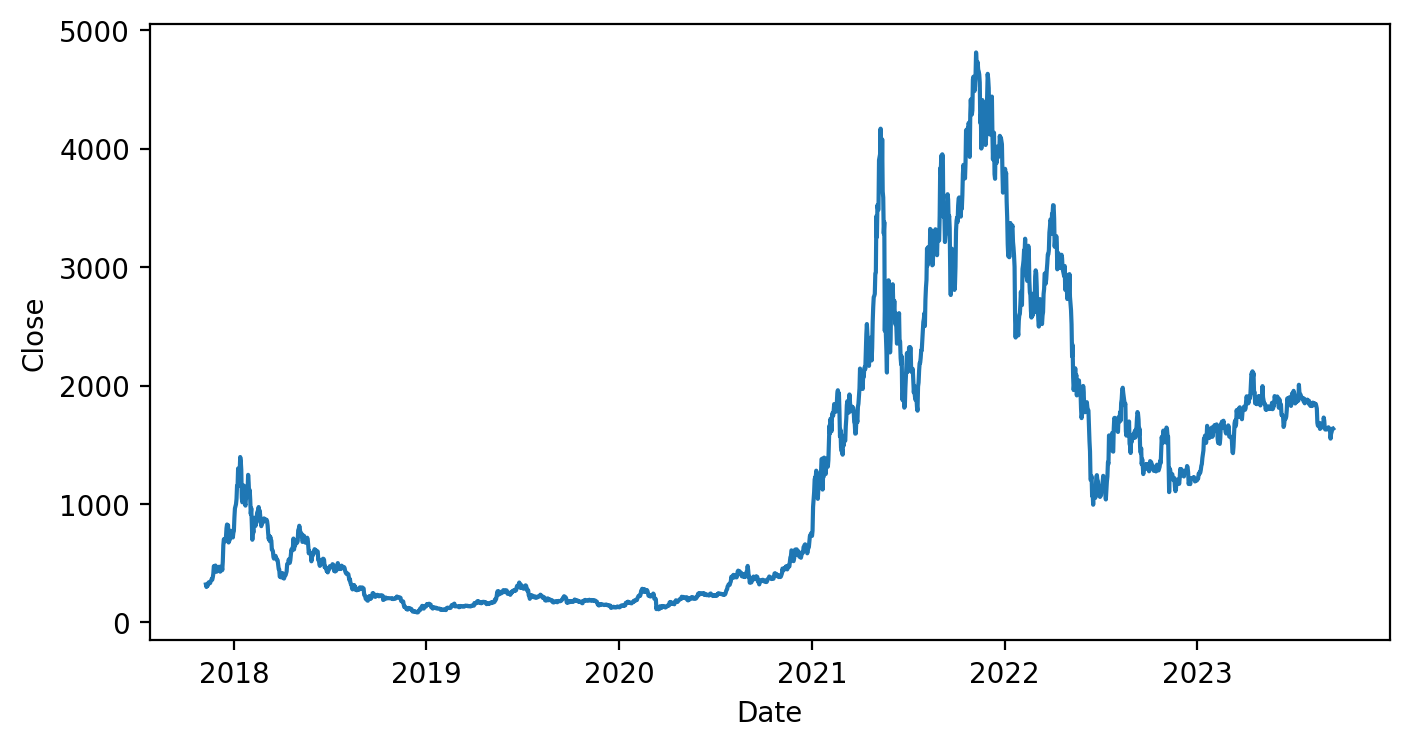

In [9]:
# close price
plt.figure(figsize = (8, 4), facecolor = "white")

sns.lineplot(
    data = df_ETH,
    x = "Date", y = "Close"
)

plt.show()

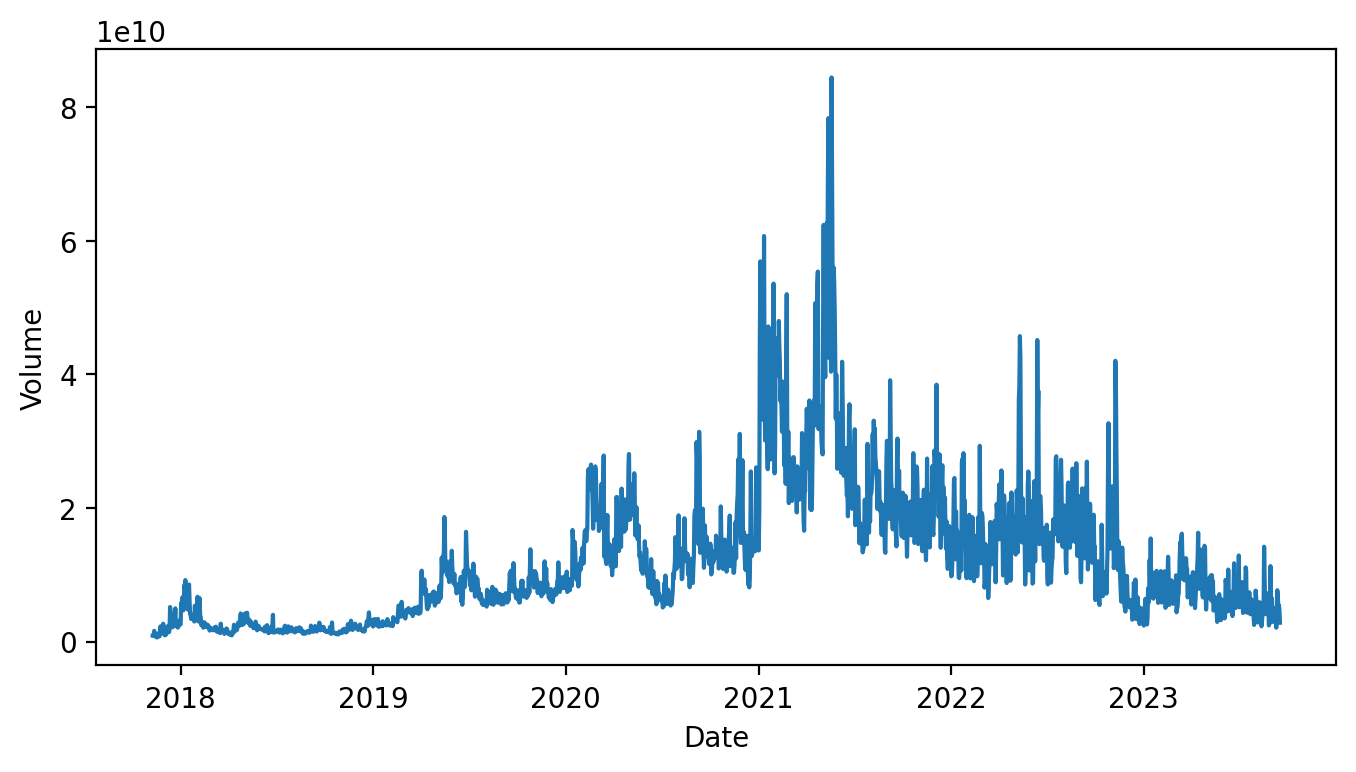

In [10]:
# volume
plt.figure(figsize = (8, 4), facecolor = "white")

sns.lineplot(
    data = df_ETH,
    x = "Date", y = "Volume"
)

plt.show()

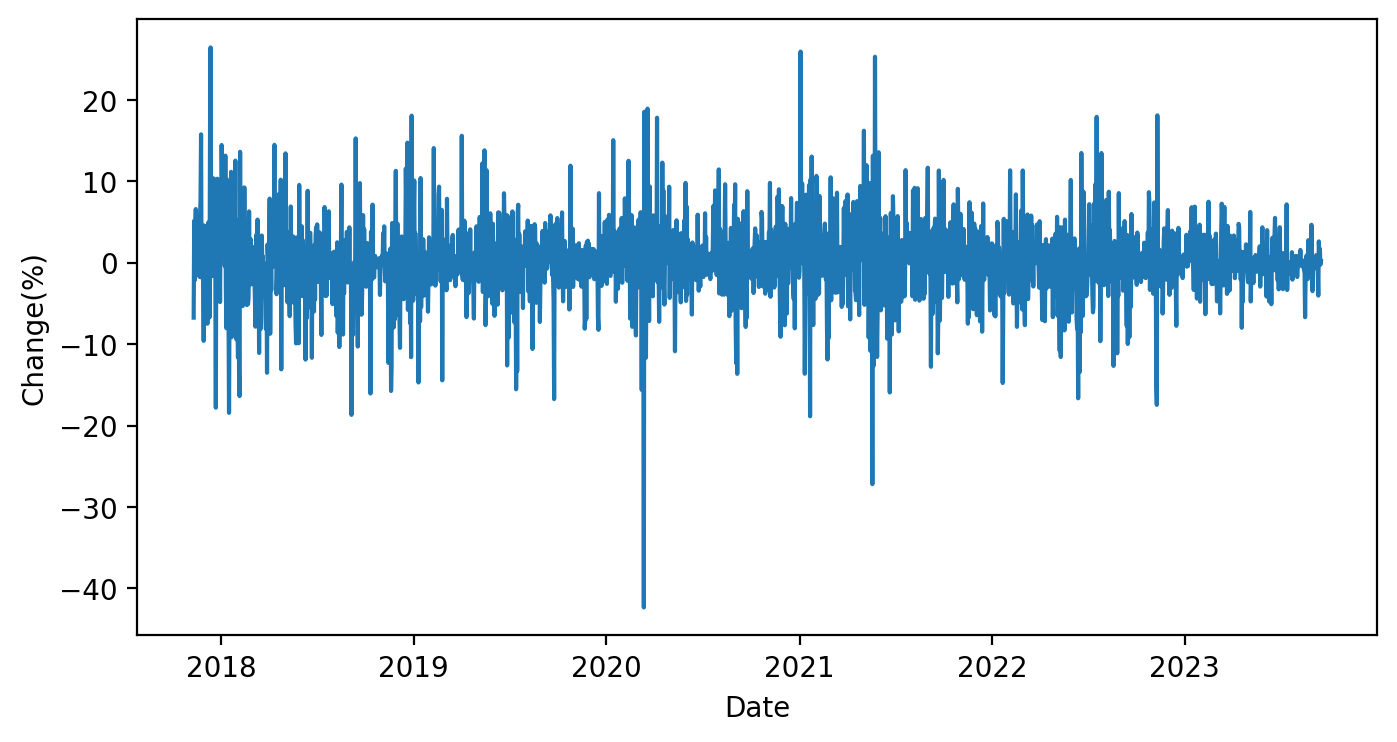

In [11]:
# percentage change
df_ETH["Change(%)"] = (df_ETH["Close"] - df_ETH["Close"].shift(1)) / df_ETH["Close"].shift(1) * 100

plt.figure(figsize = (8, 4), facecolor = "white")

sns.lineplot(
    data = df_ETH,
    x = "Date", y = "Change(%)"
)

plt.show()

## 2.2. Distribution

In [12]:
def summary_numerical_dist(df_data, col, q_min, q_max):
    
    # plot size
    fig = plt.figure(figsize = (10, 8), facecolor = "white")


    # setting subplot
    layout_plot = (2, 2)
    num_subplot = 4
    axes = [None for _ in range(num_subplot)]

    list_shape_subplot = [
        [(0, 0), (0, 1), (1, 0), (1, 1)], # loc
        [1, 1, 1, 1], # rowspan
        [1, 1, 1, 1] # colspan
    ]

    for i in range(num_subplot):
        axes[i] = plt.subplot2grid(
            layout_plot, list_shape_subplot[0][i],
            rowspan = list_shape_subplot[1][i],
            colspan = list_shape_subplot[2][i]
        )

    
    # histplot: axes[0]
    sns.histplot(
        data = df_data,
        x = col,
        kde = True,
        ax = axes[0]
    )
    
    
    # QQ plot: axes[1]
    stats.probplot(
        x = df_data[col],
        dist = stats.norm,
        plot = axes[1]
    )
    
    
    # boxplot, to detect outlier: axes[2]
    sns.boxplot(
        data = df_data,
        x = col,
        ax = axes[2]
    )
    
    
    # lineplot, to detect outlier: axes[3]
    pts = df_data[col].quantile(q = np.arange(q_min, q_max, 0.01))
    sns.lineplot(
        x = pts.index,
        y = pts,
        ax = axes[3]
    )
    axes[3].grid(True)
    
    
    # lists
    list_title = ["Histogram", "QQ plot", "Boxplot", "Outlier"]
    
    for i in range(num_subplot):
        # title
        axes[i].set_title(list_title[i])
        
    
    # suptitle
    plt.suptitle(f"Distribution of: {col}", fontsize = 15)
    
    
    # interval adjustment and output
    plt.tight_layout()
    plt.show()

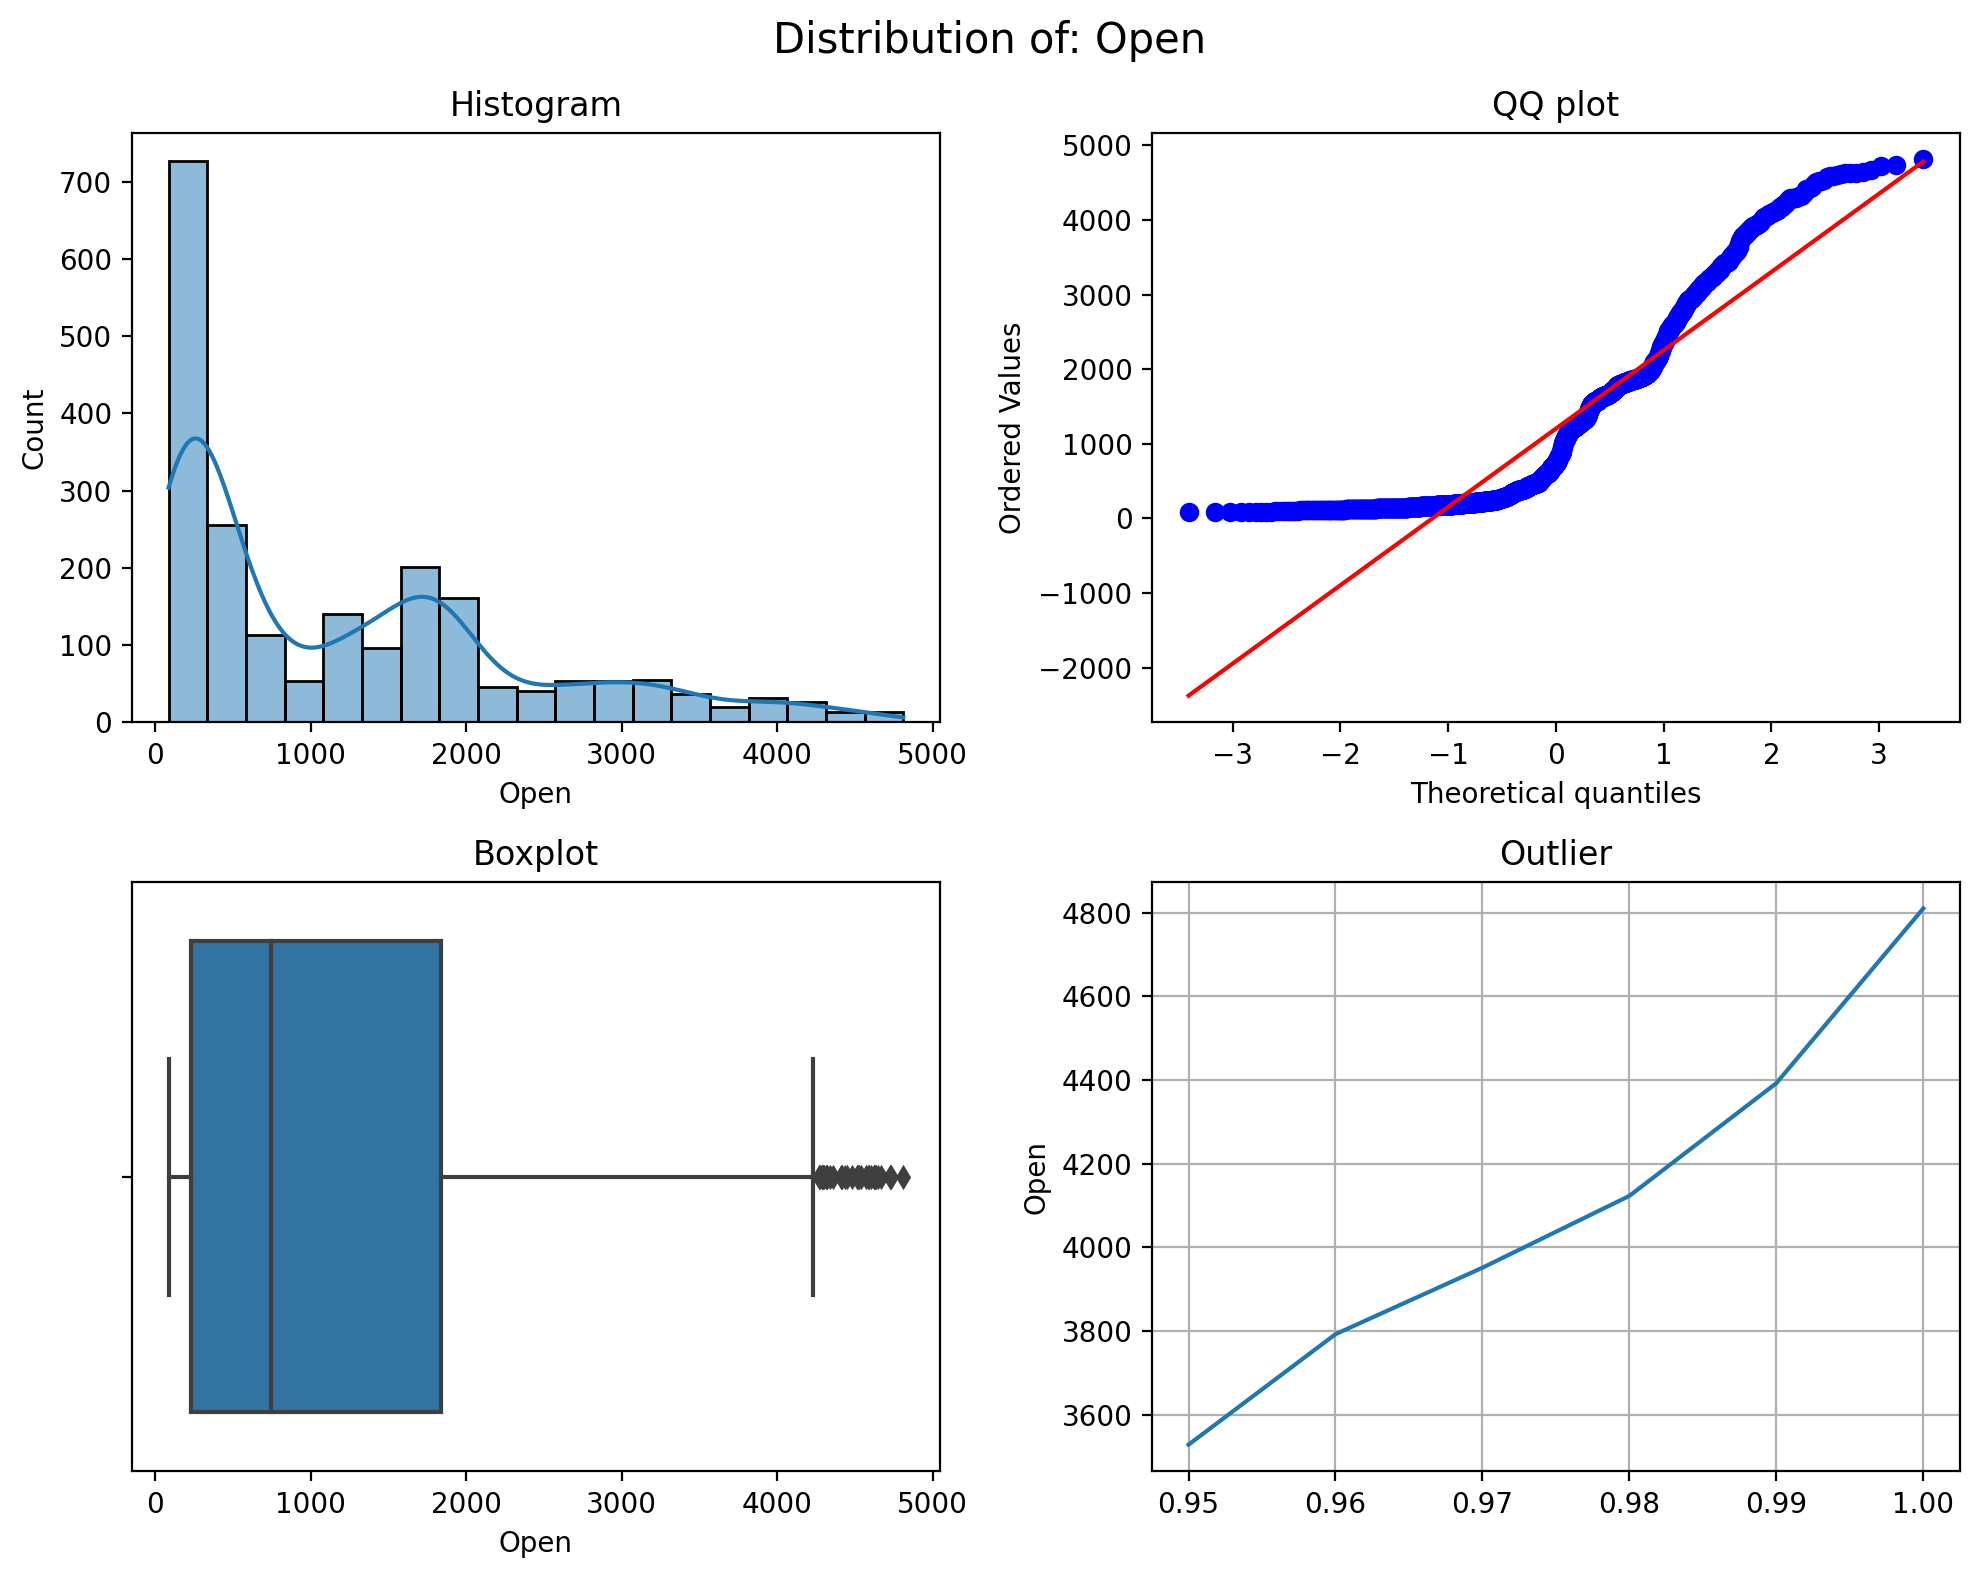

In [13]:
summary_numerical_dist(df_ETH, 'Open', .95, 1)

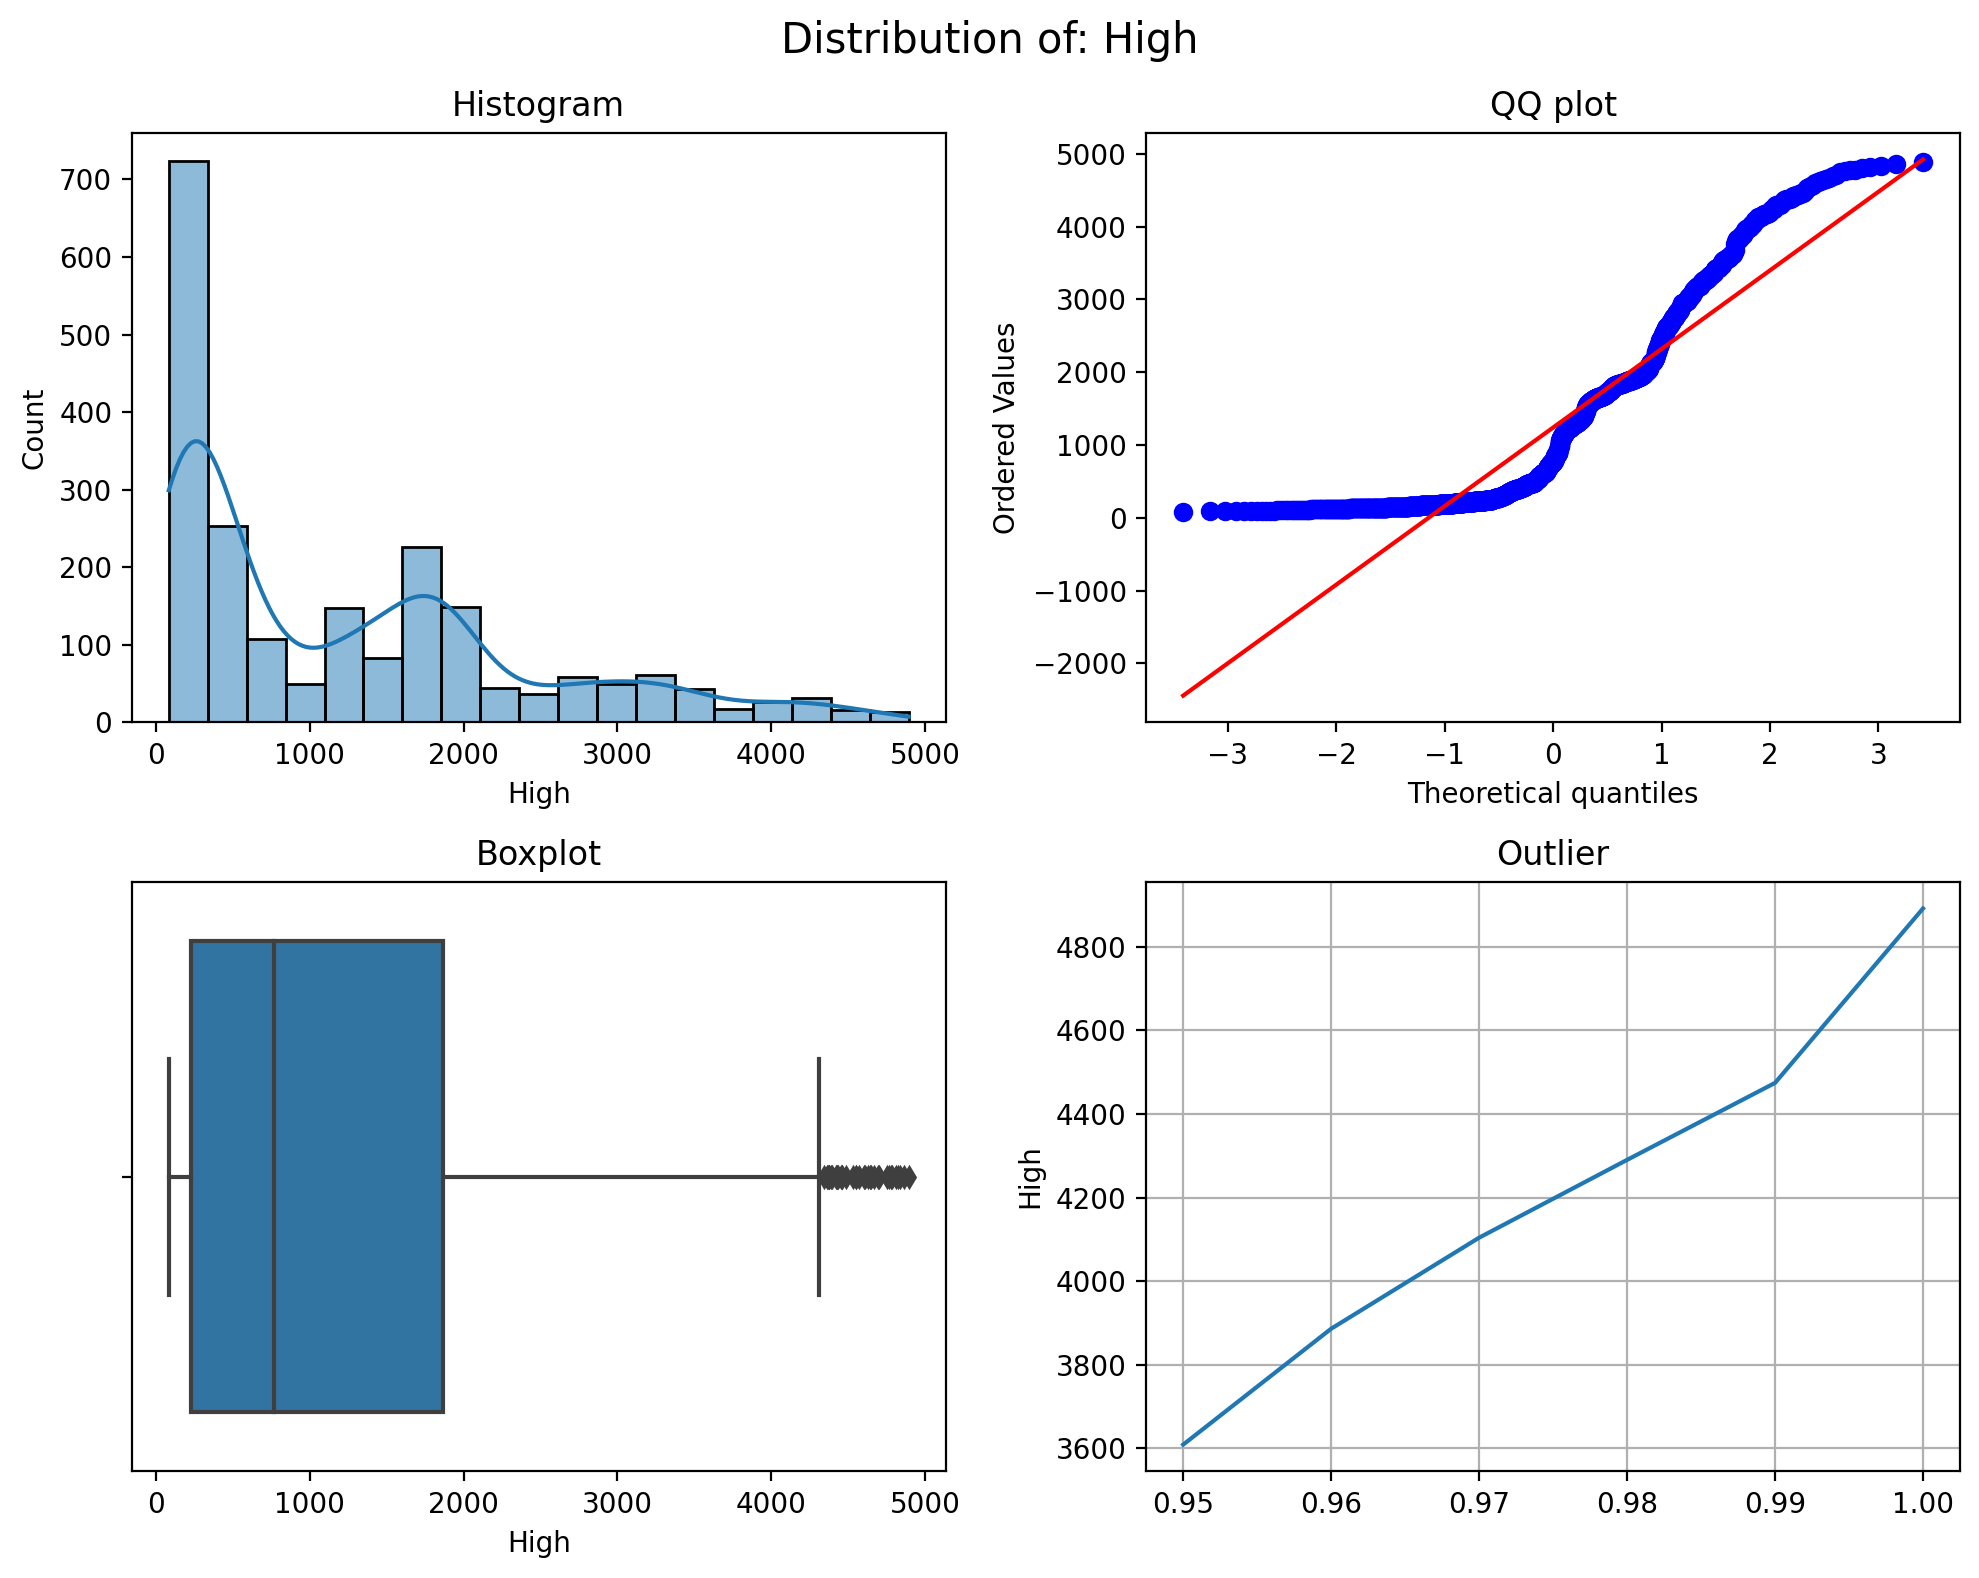

In [14]:
summary_numerical_dist(df_ETH, 'High', .95, 1)

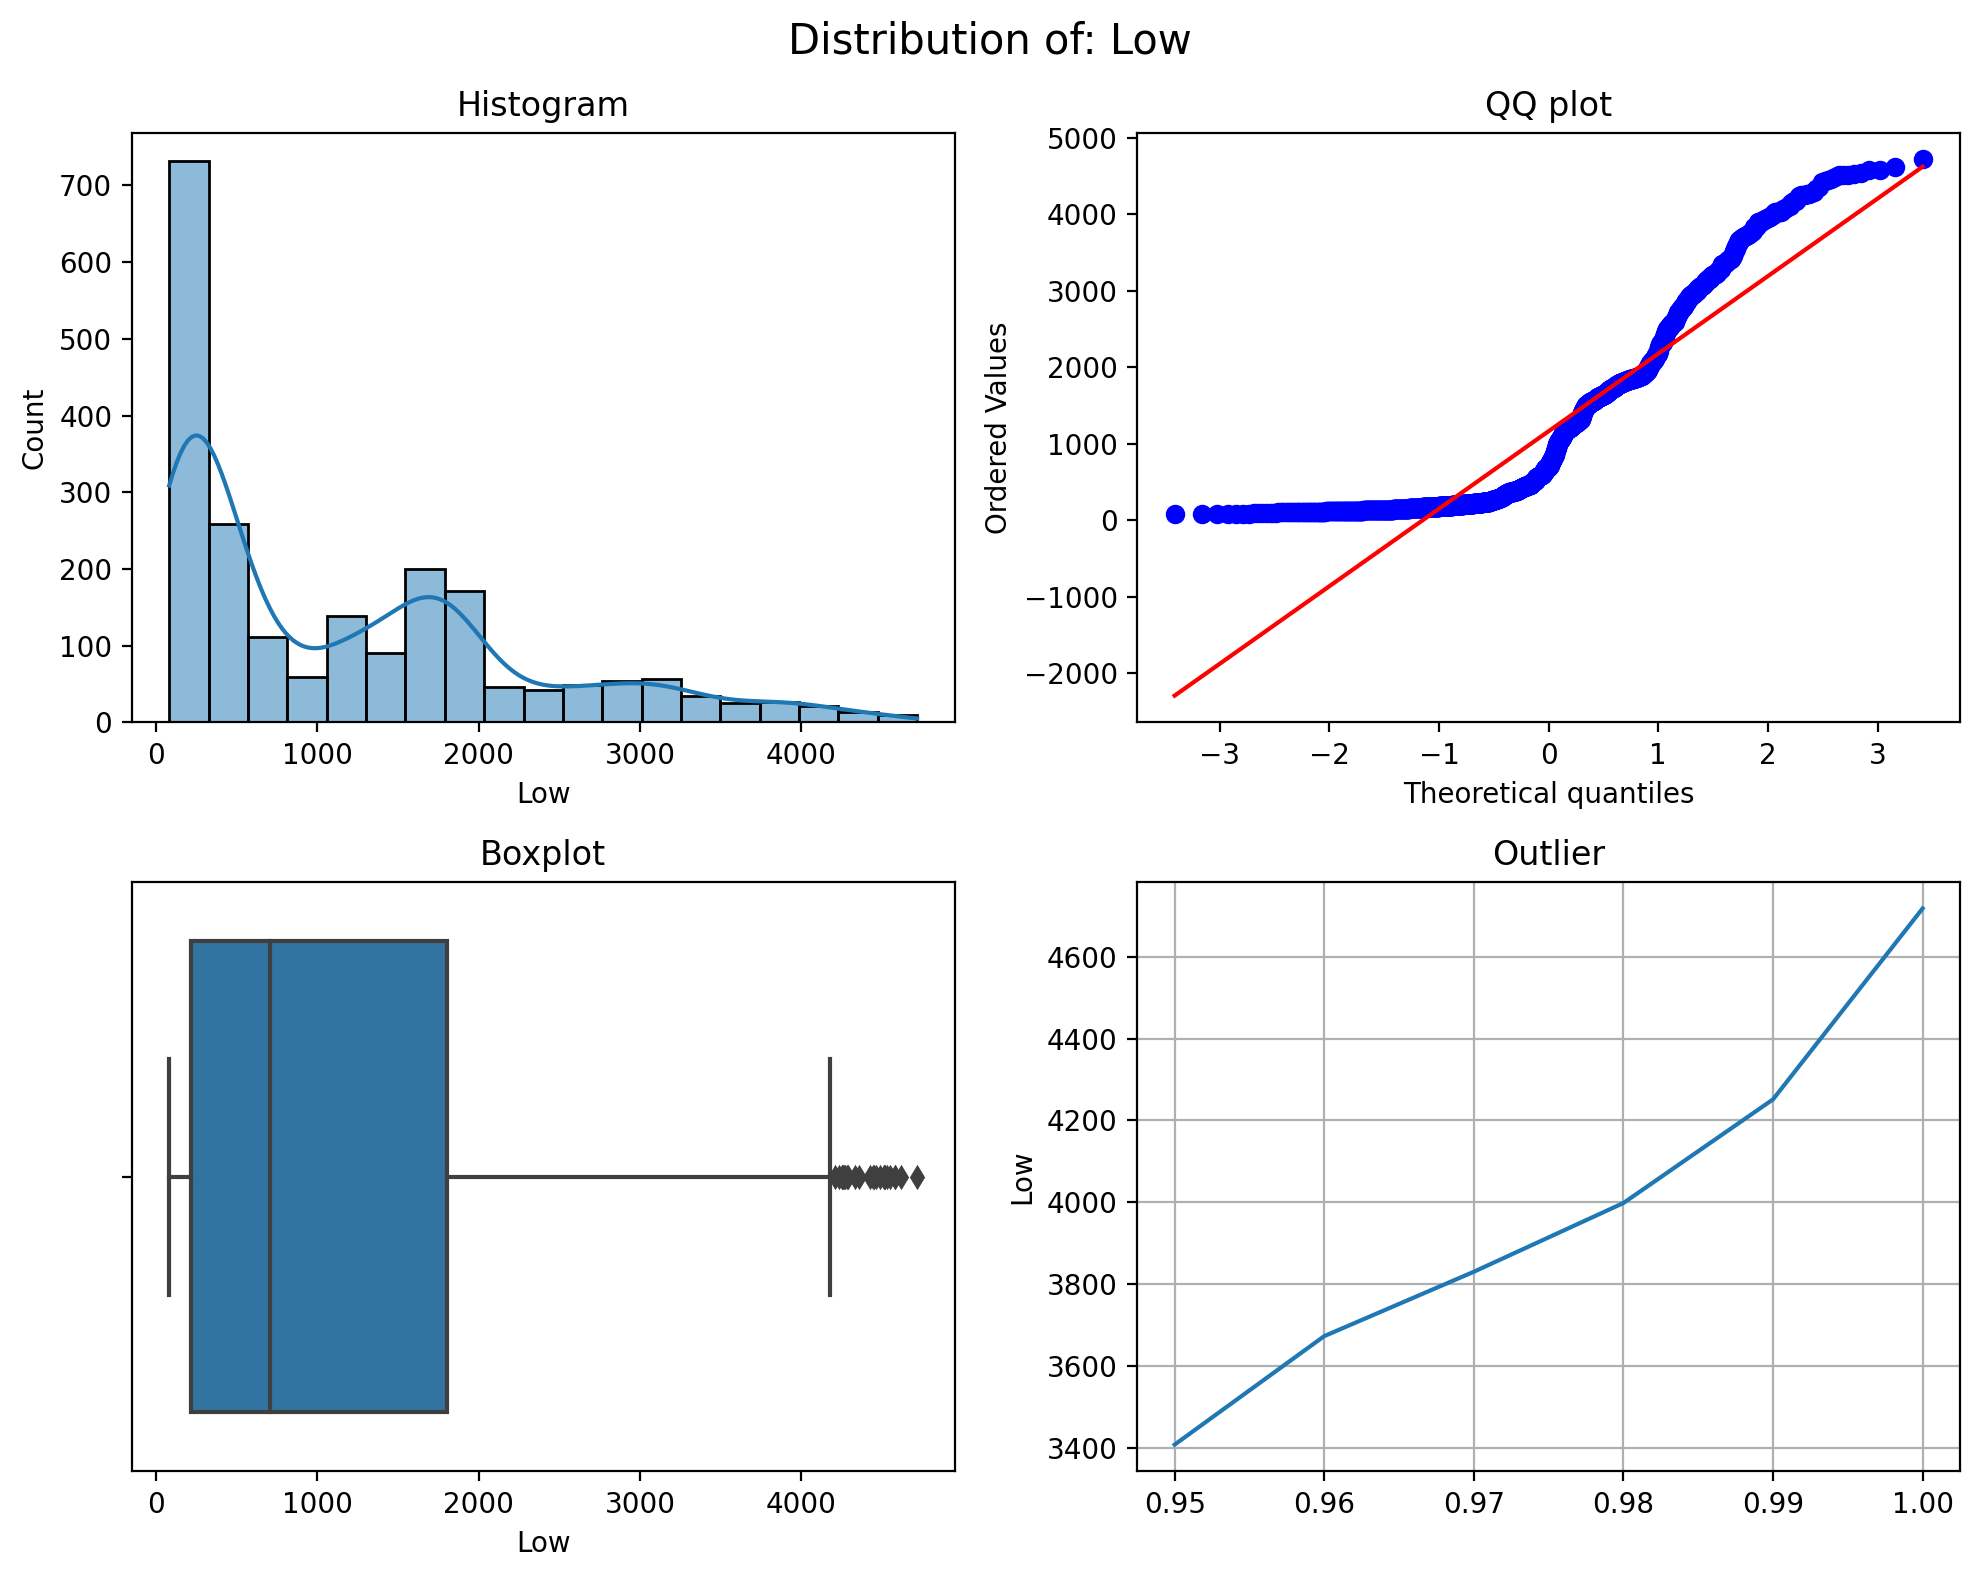

In [15]:
summary_numerical_dist(df_ETH, 'Low', .95, 1)

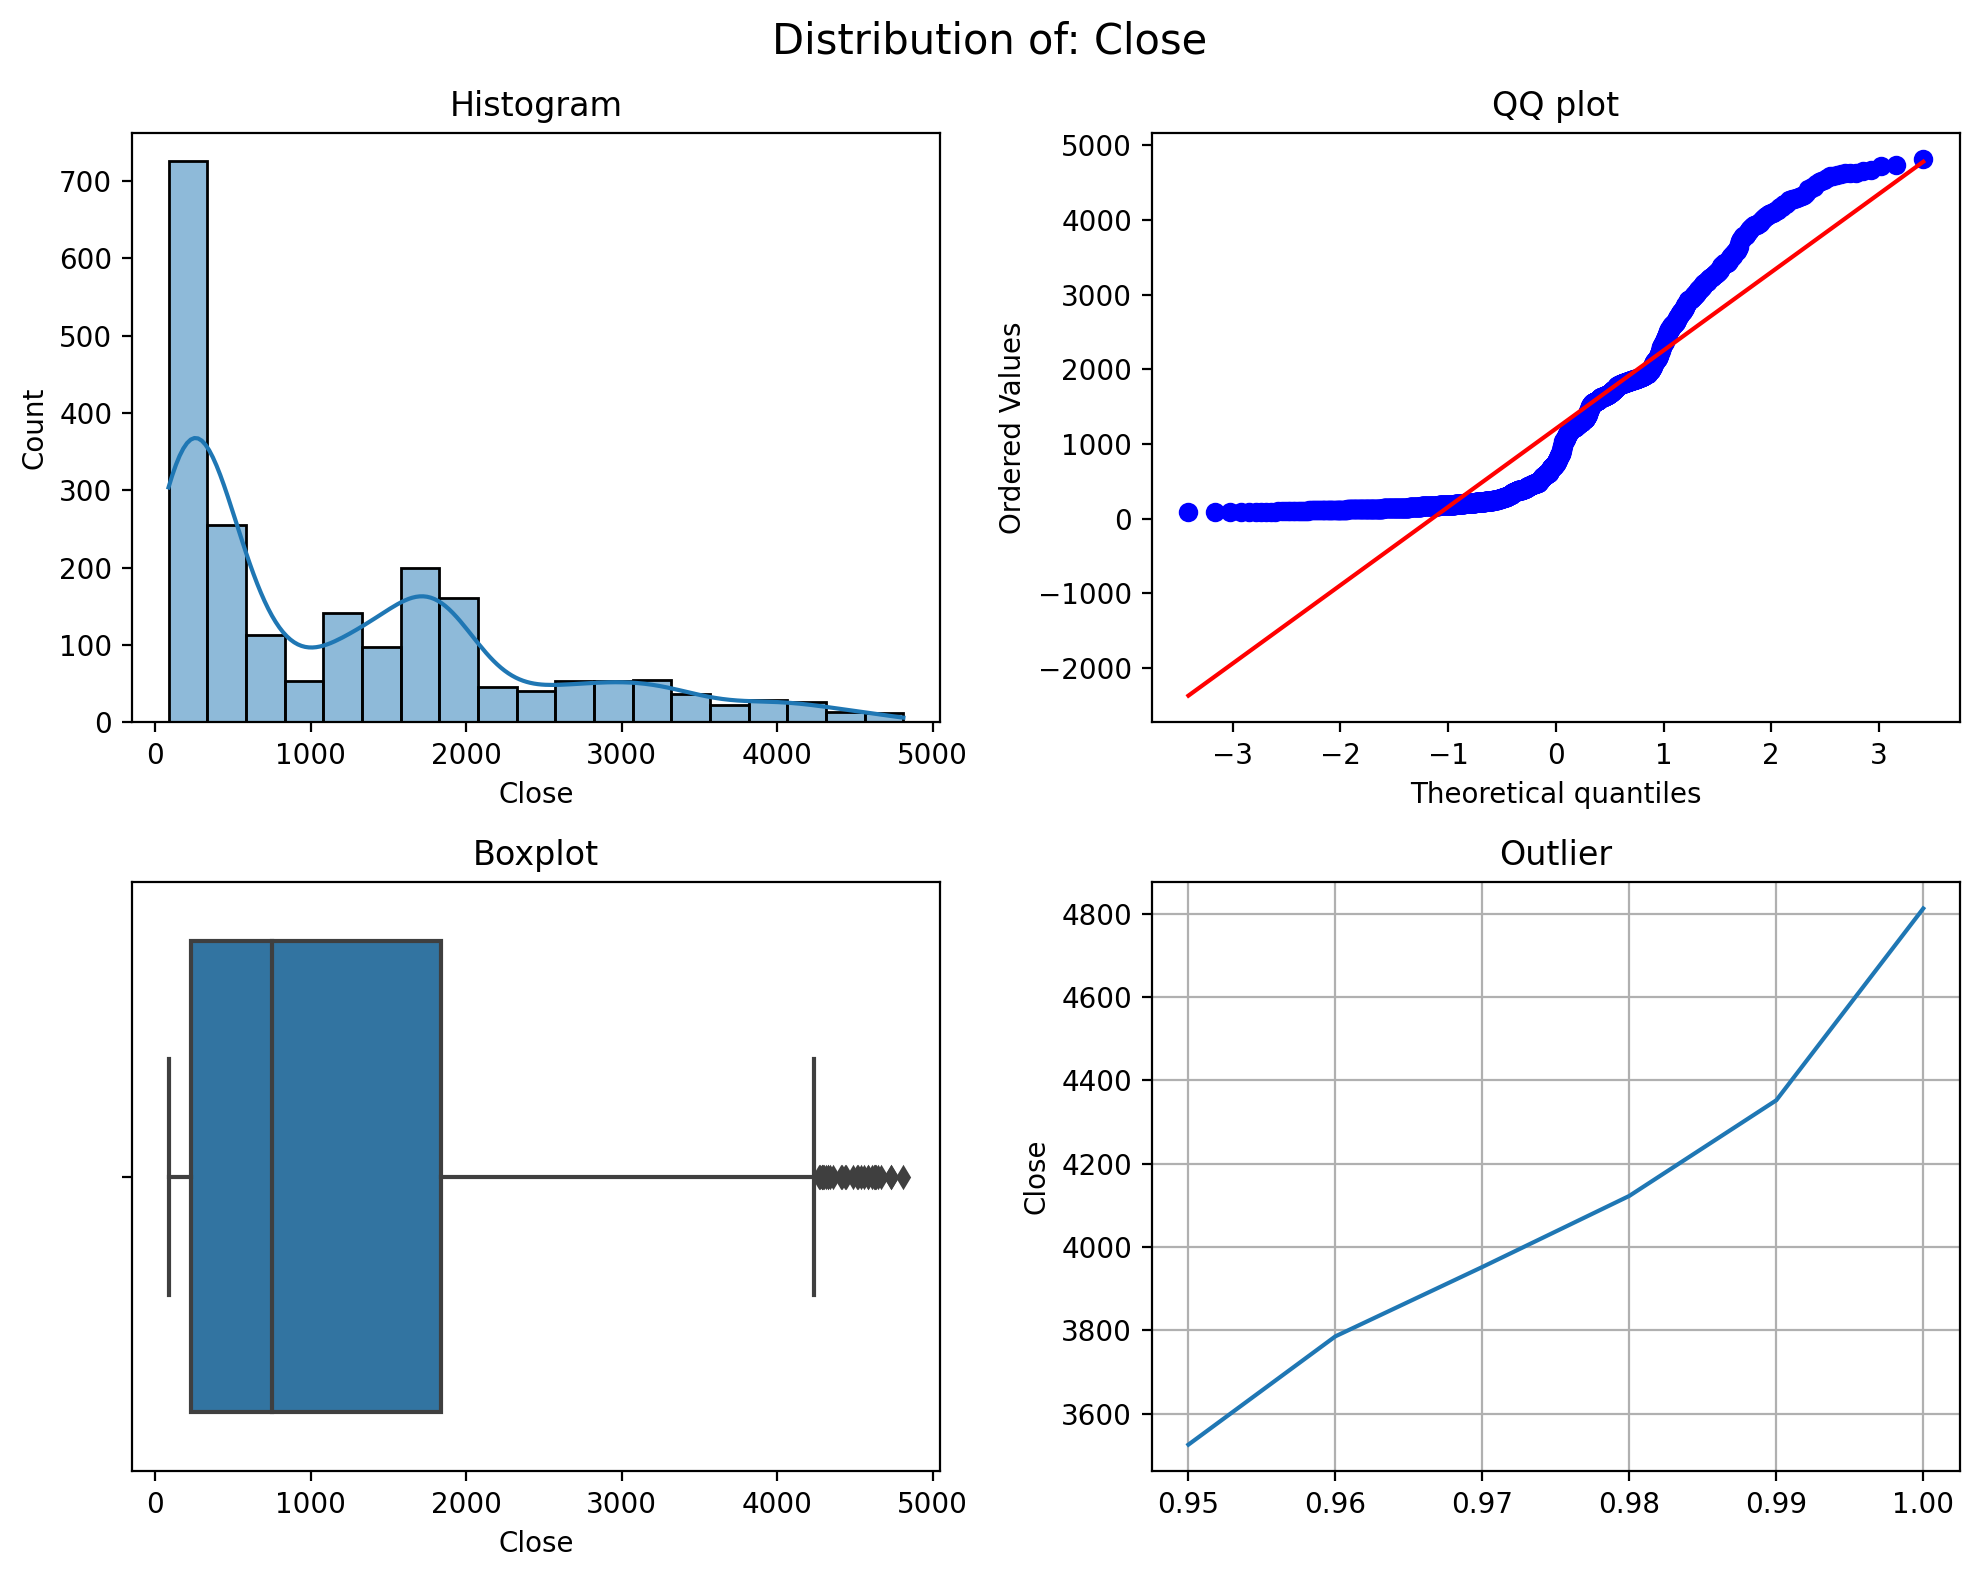

In [16]:
summary_numerical_dist(df_ETH, 'Close', .95, 1)

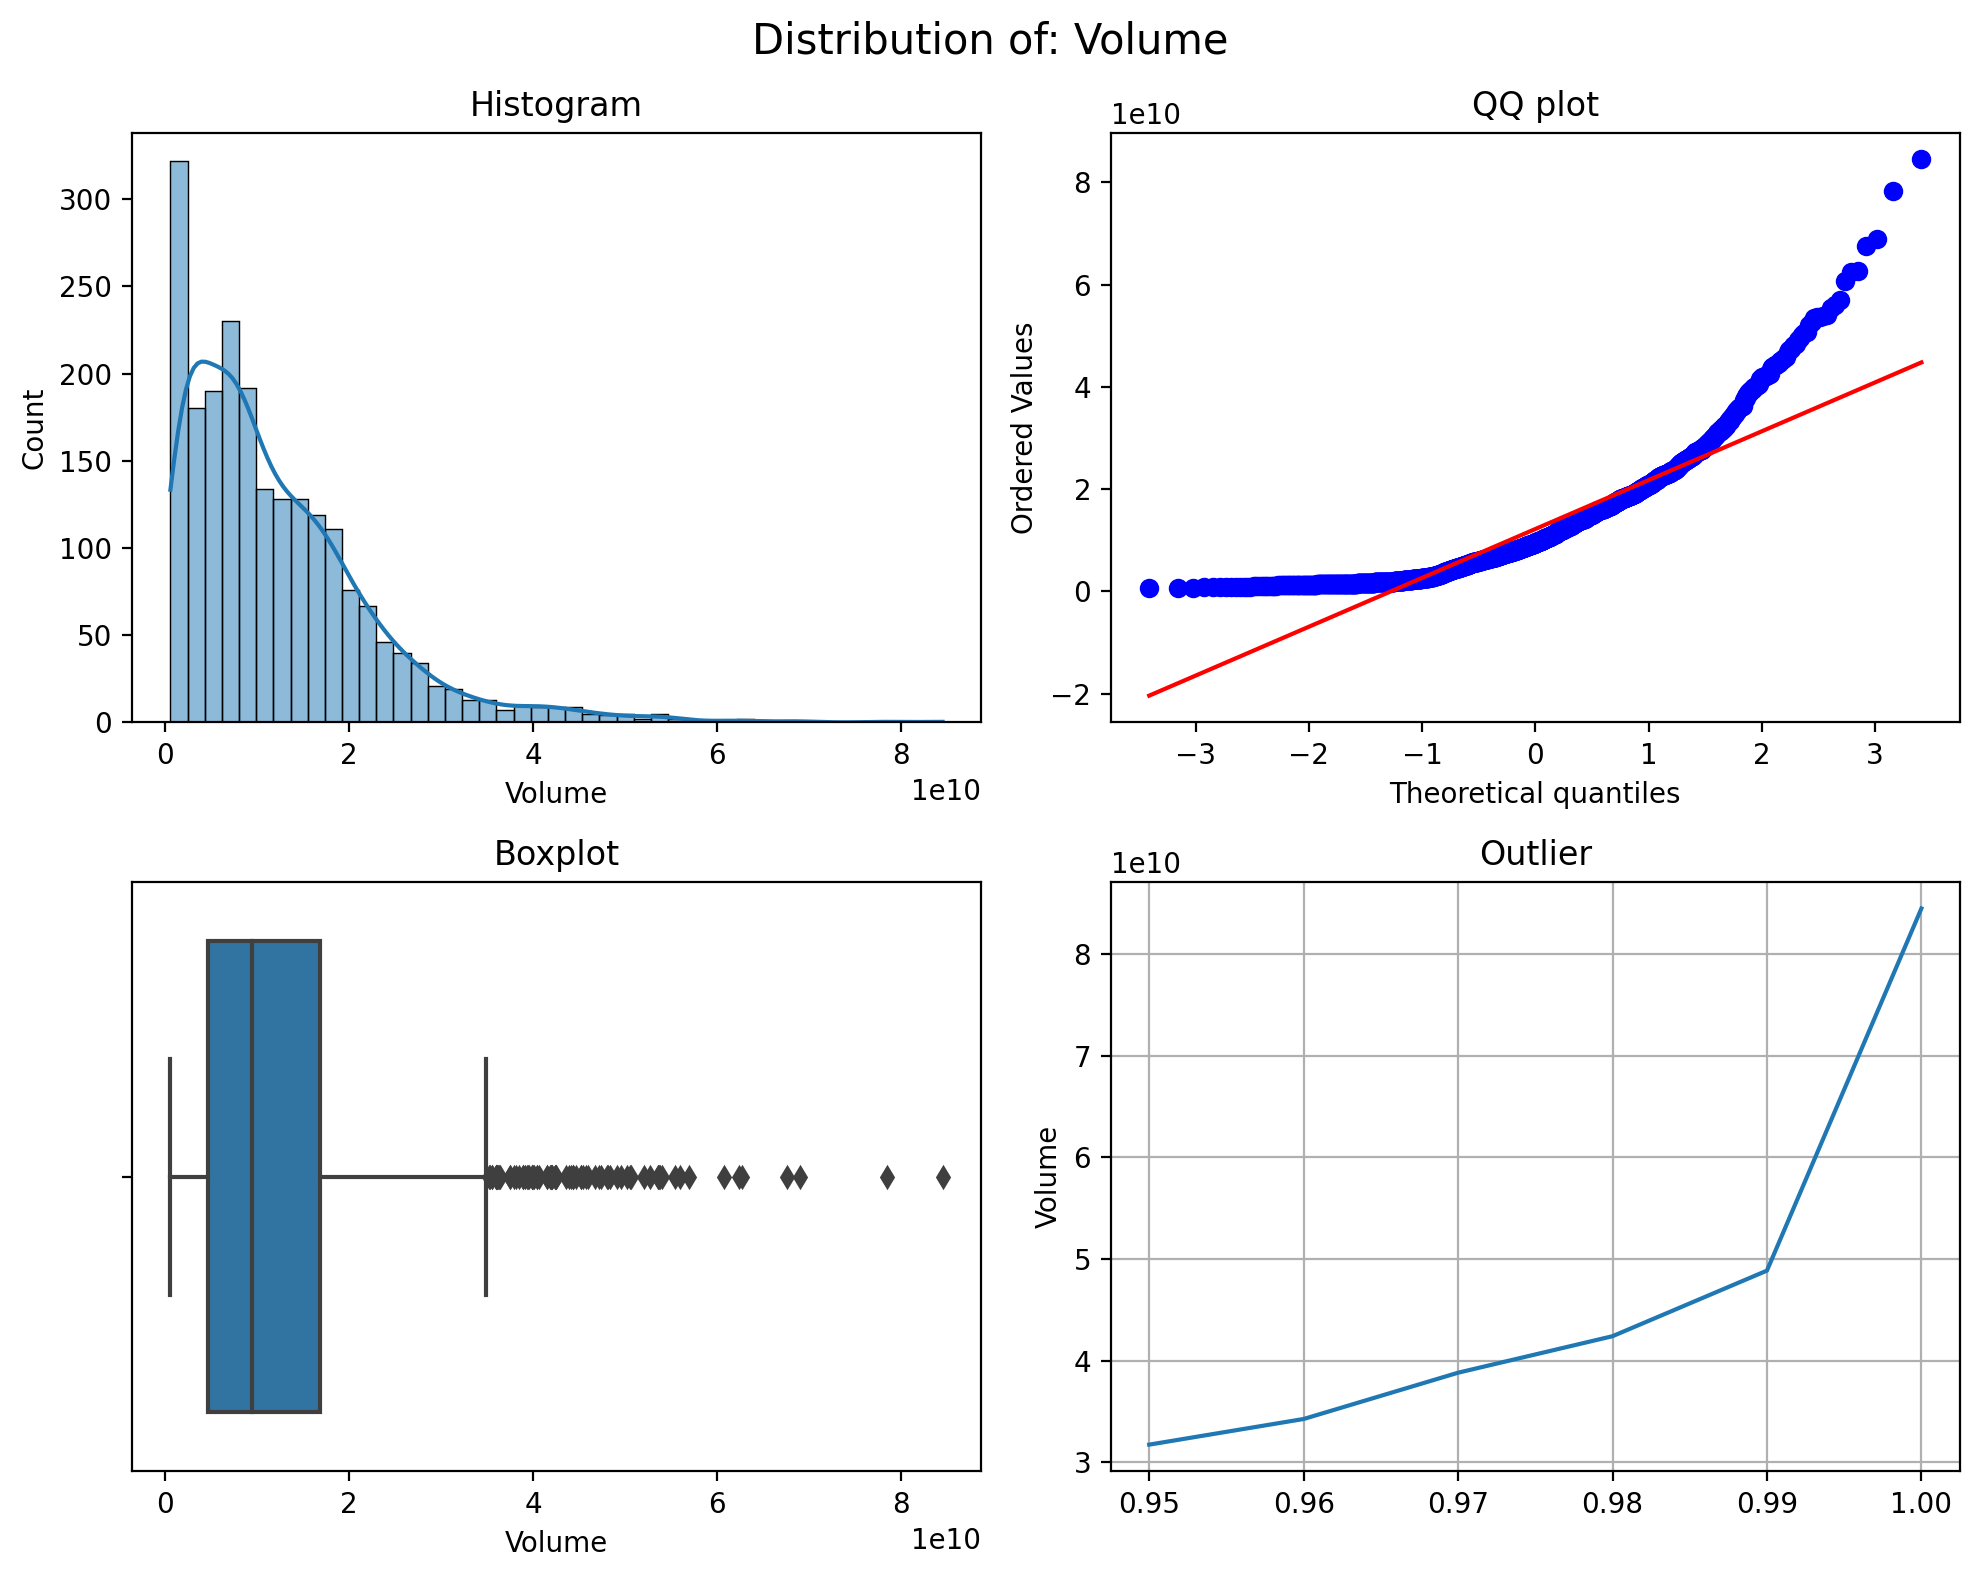

In [17]:
summary_numerical_dist(df_ETH, 'Volume', .95, 1)

Overall, it appears that a logarithmic transformation is needed as it shows a right-skewed distribution.

This statement suggests that the data being analyzed exhibits a right-skewed distribution, meaning that there are more data points concentrated on the left side of the distribution with a long tail extending towards the right. In such cases, applying a logarithmic transformation to the data can help make the distribution more symmetric or closer to a normal distribution.

# 3. Data Transformation

In [18]:
df_ETH_transformed = pd.DataFrame()

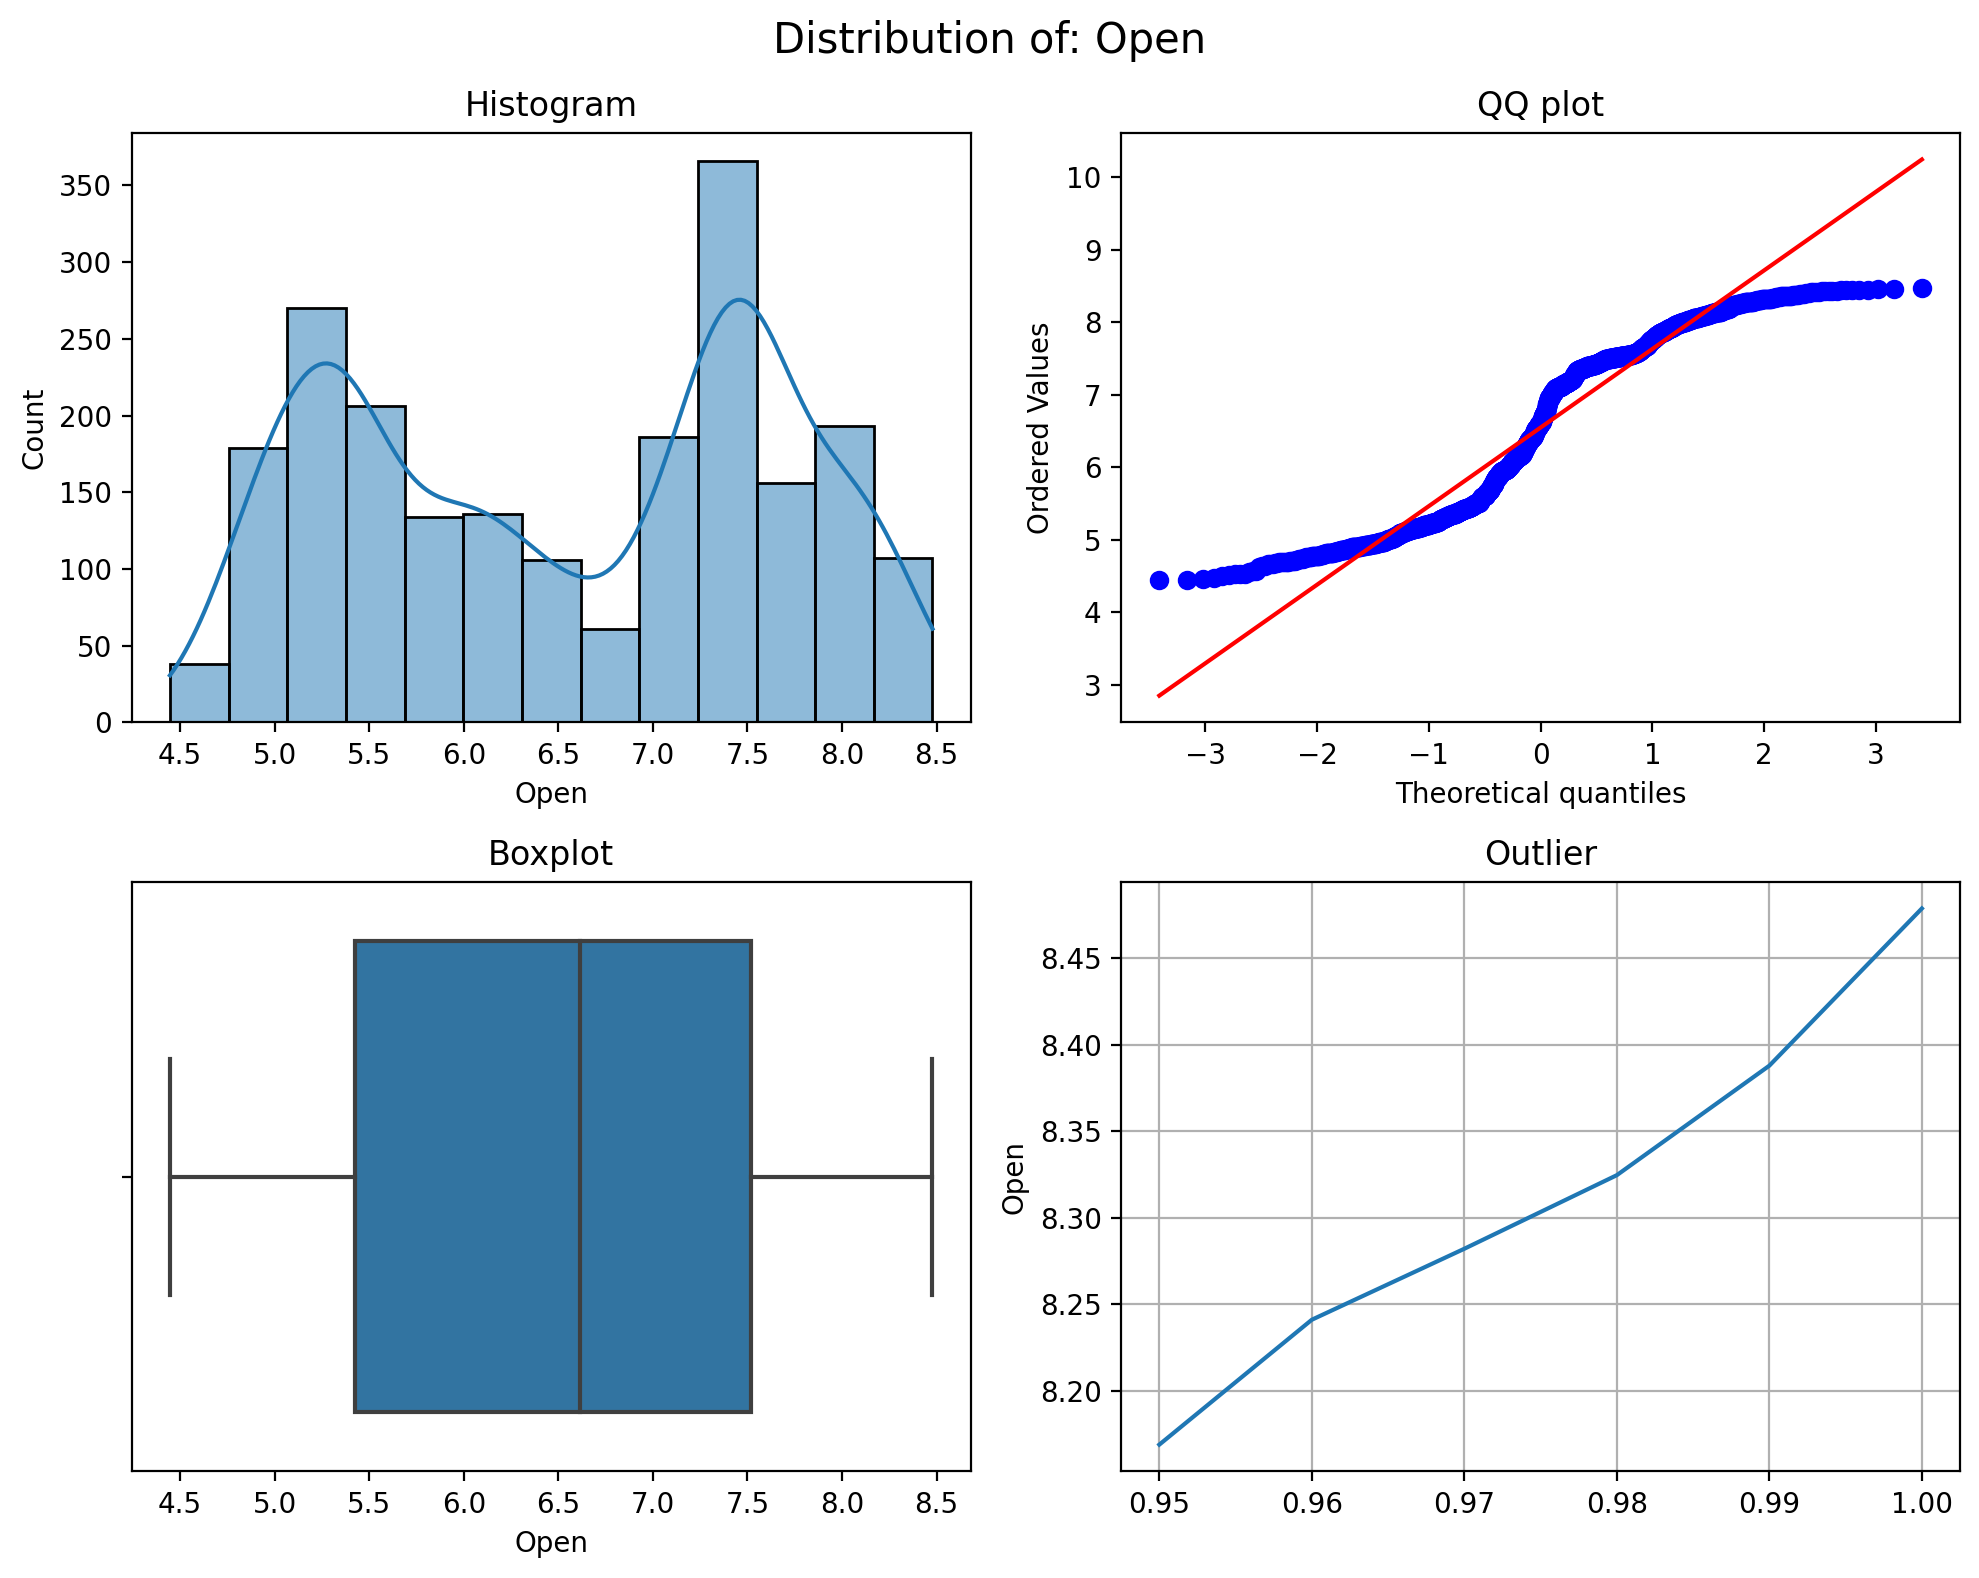

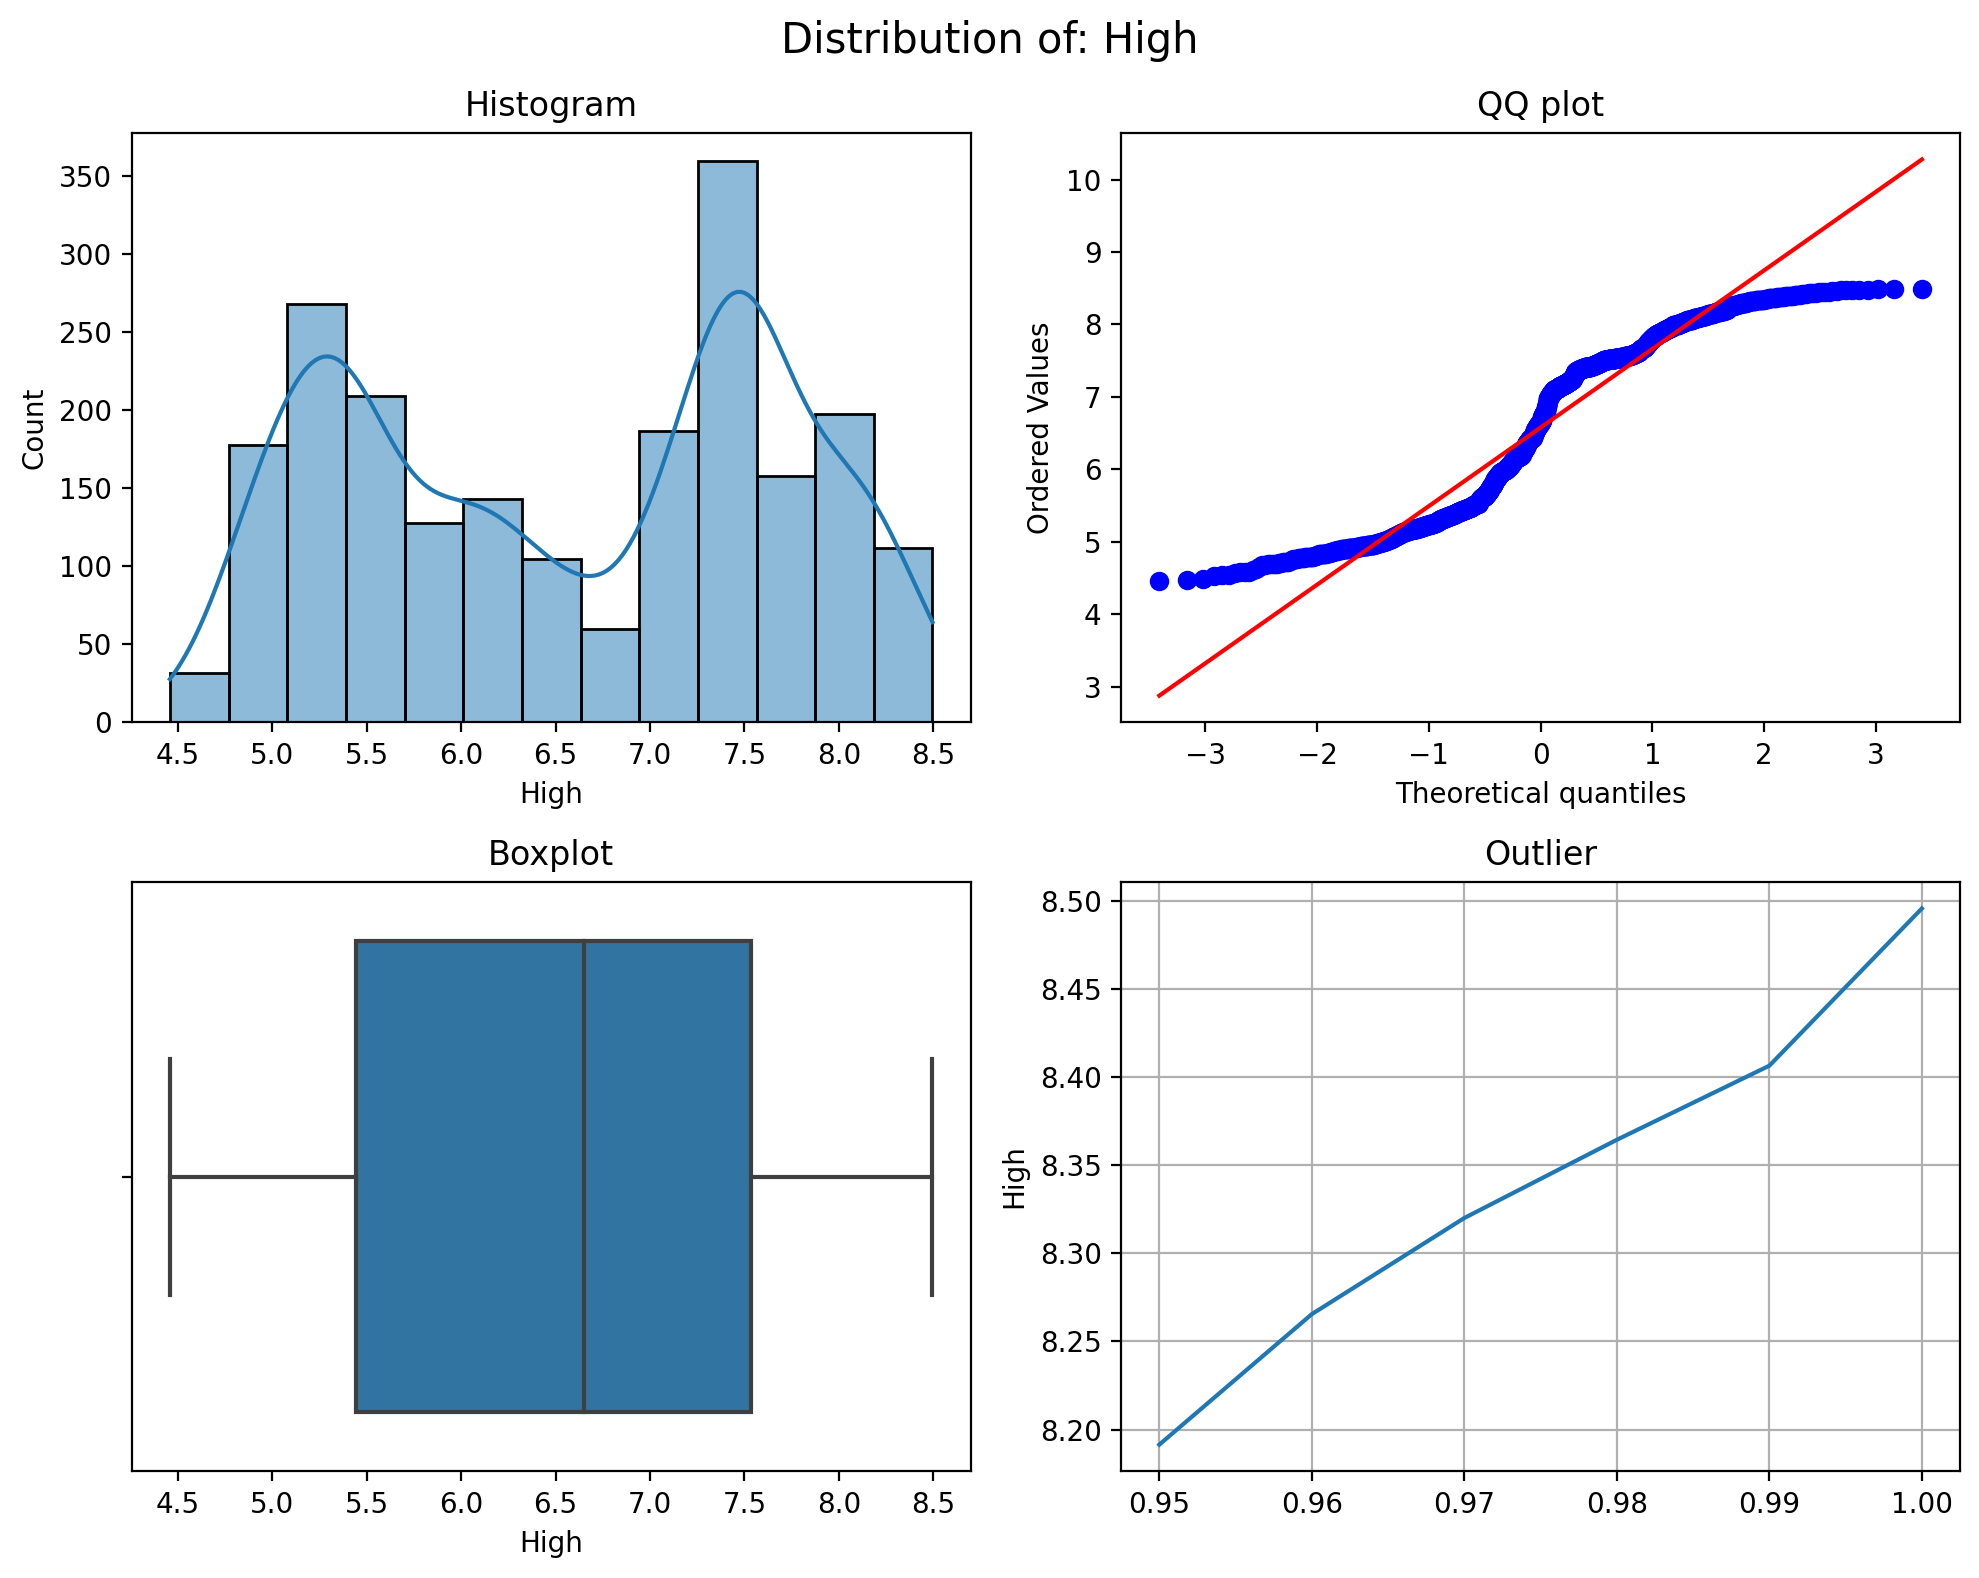

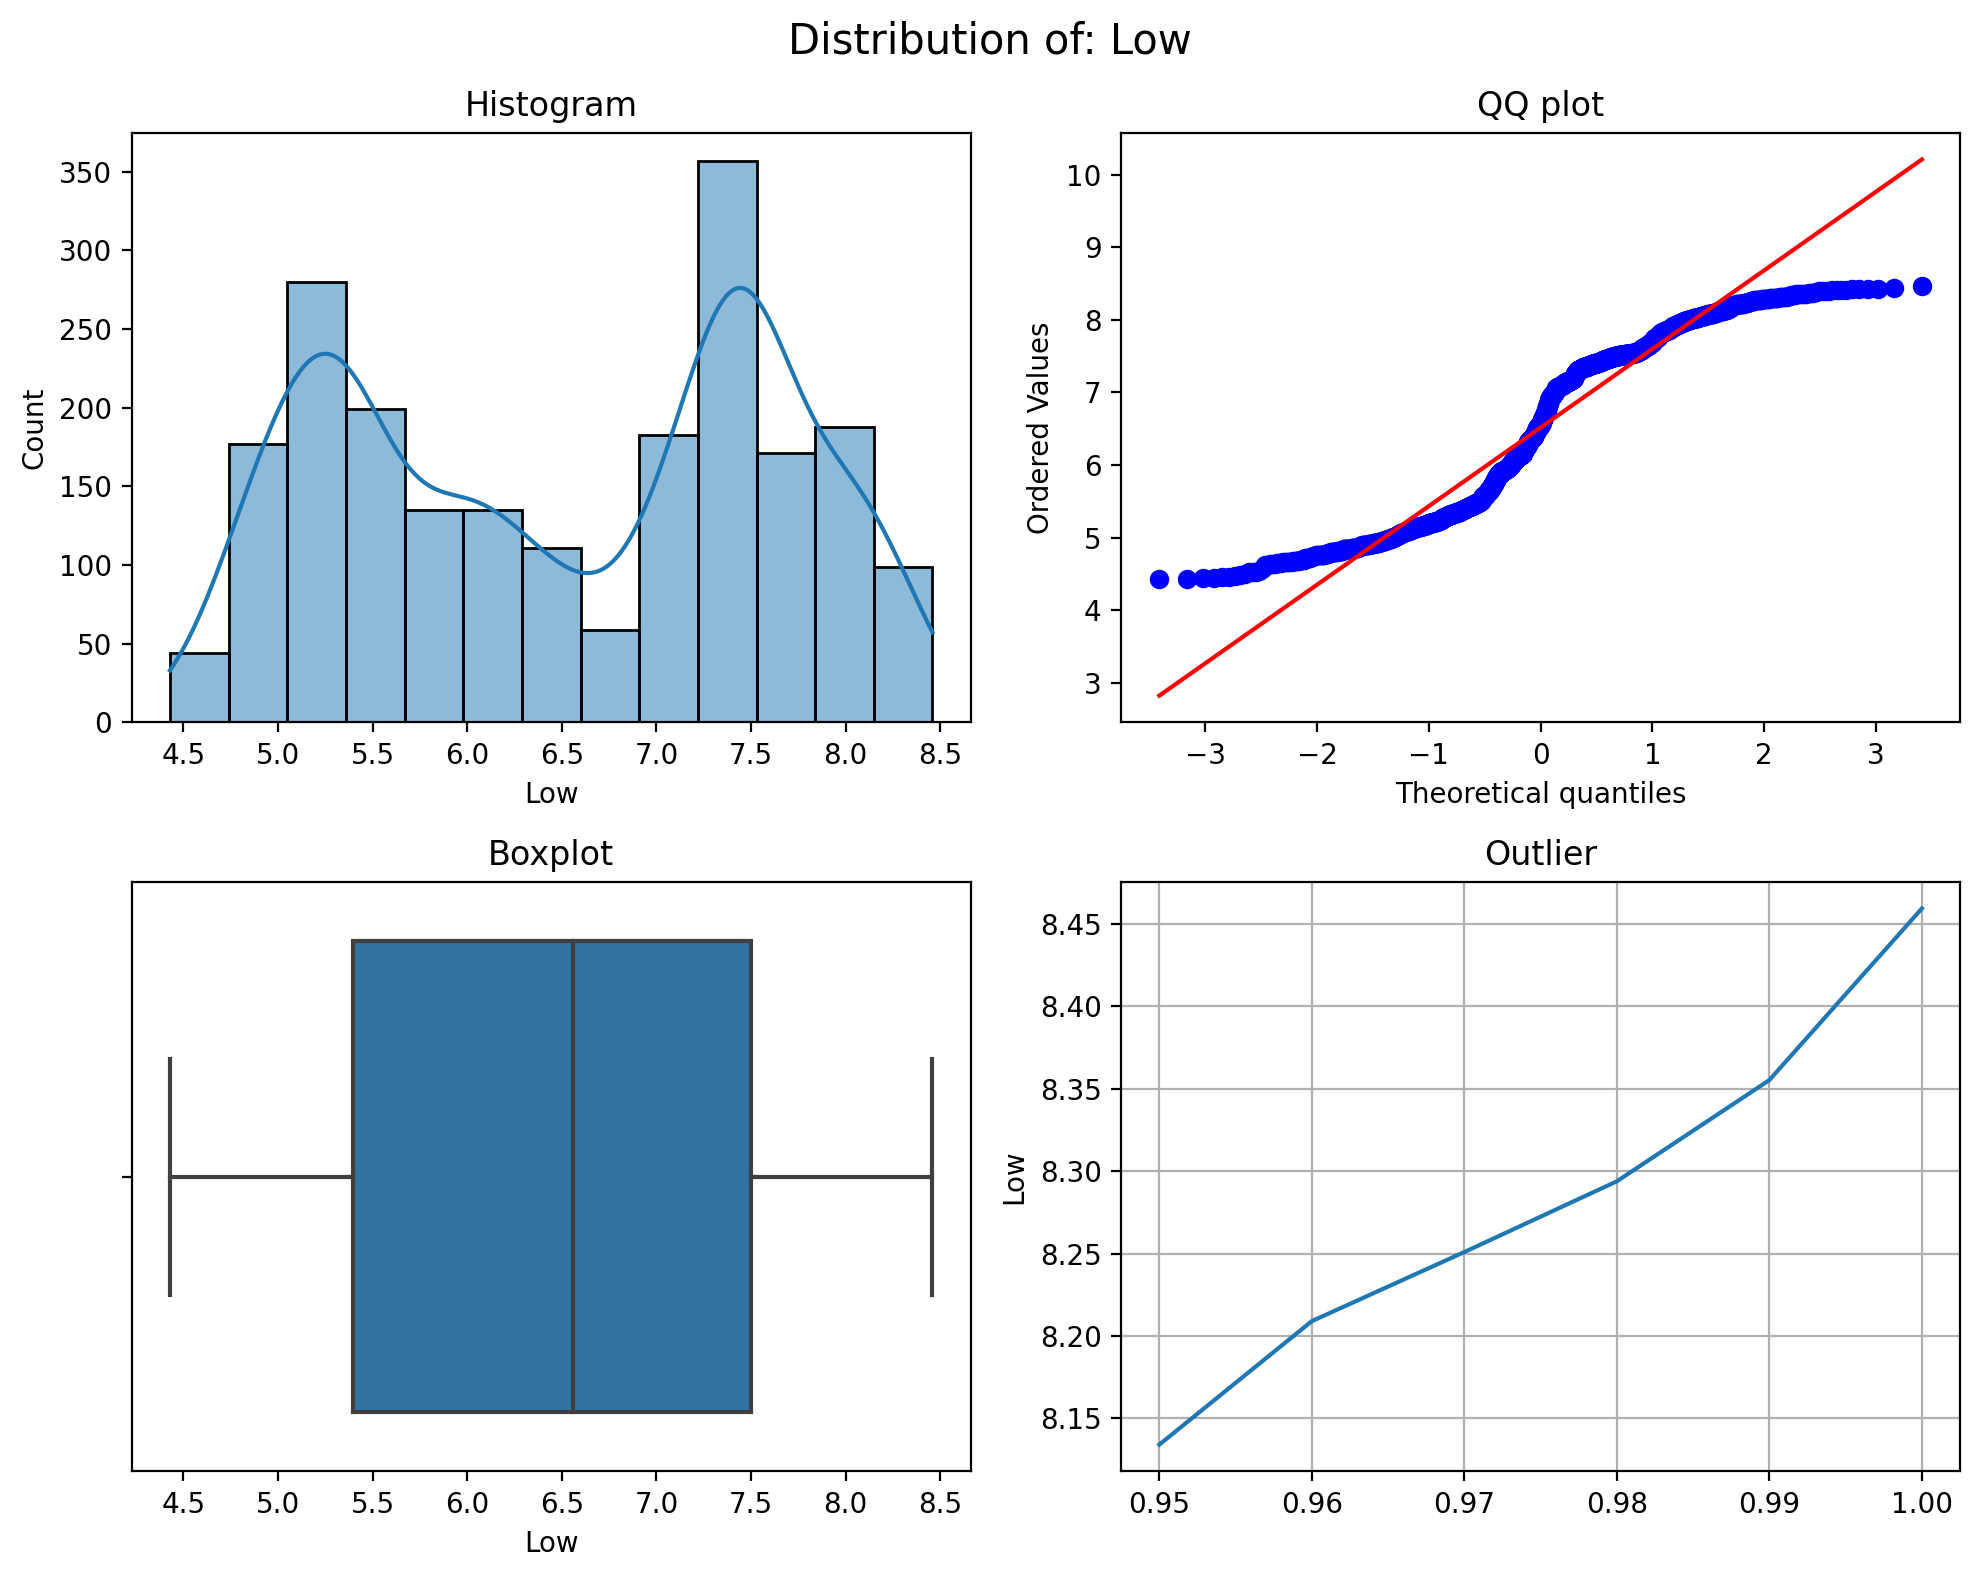

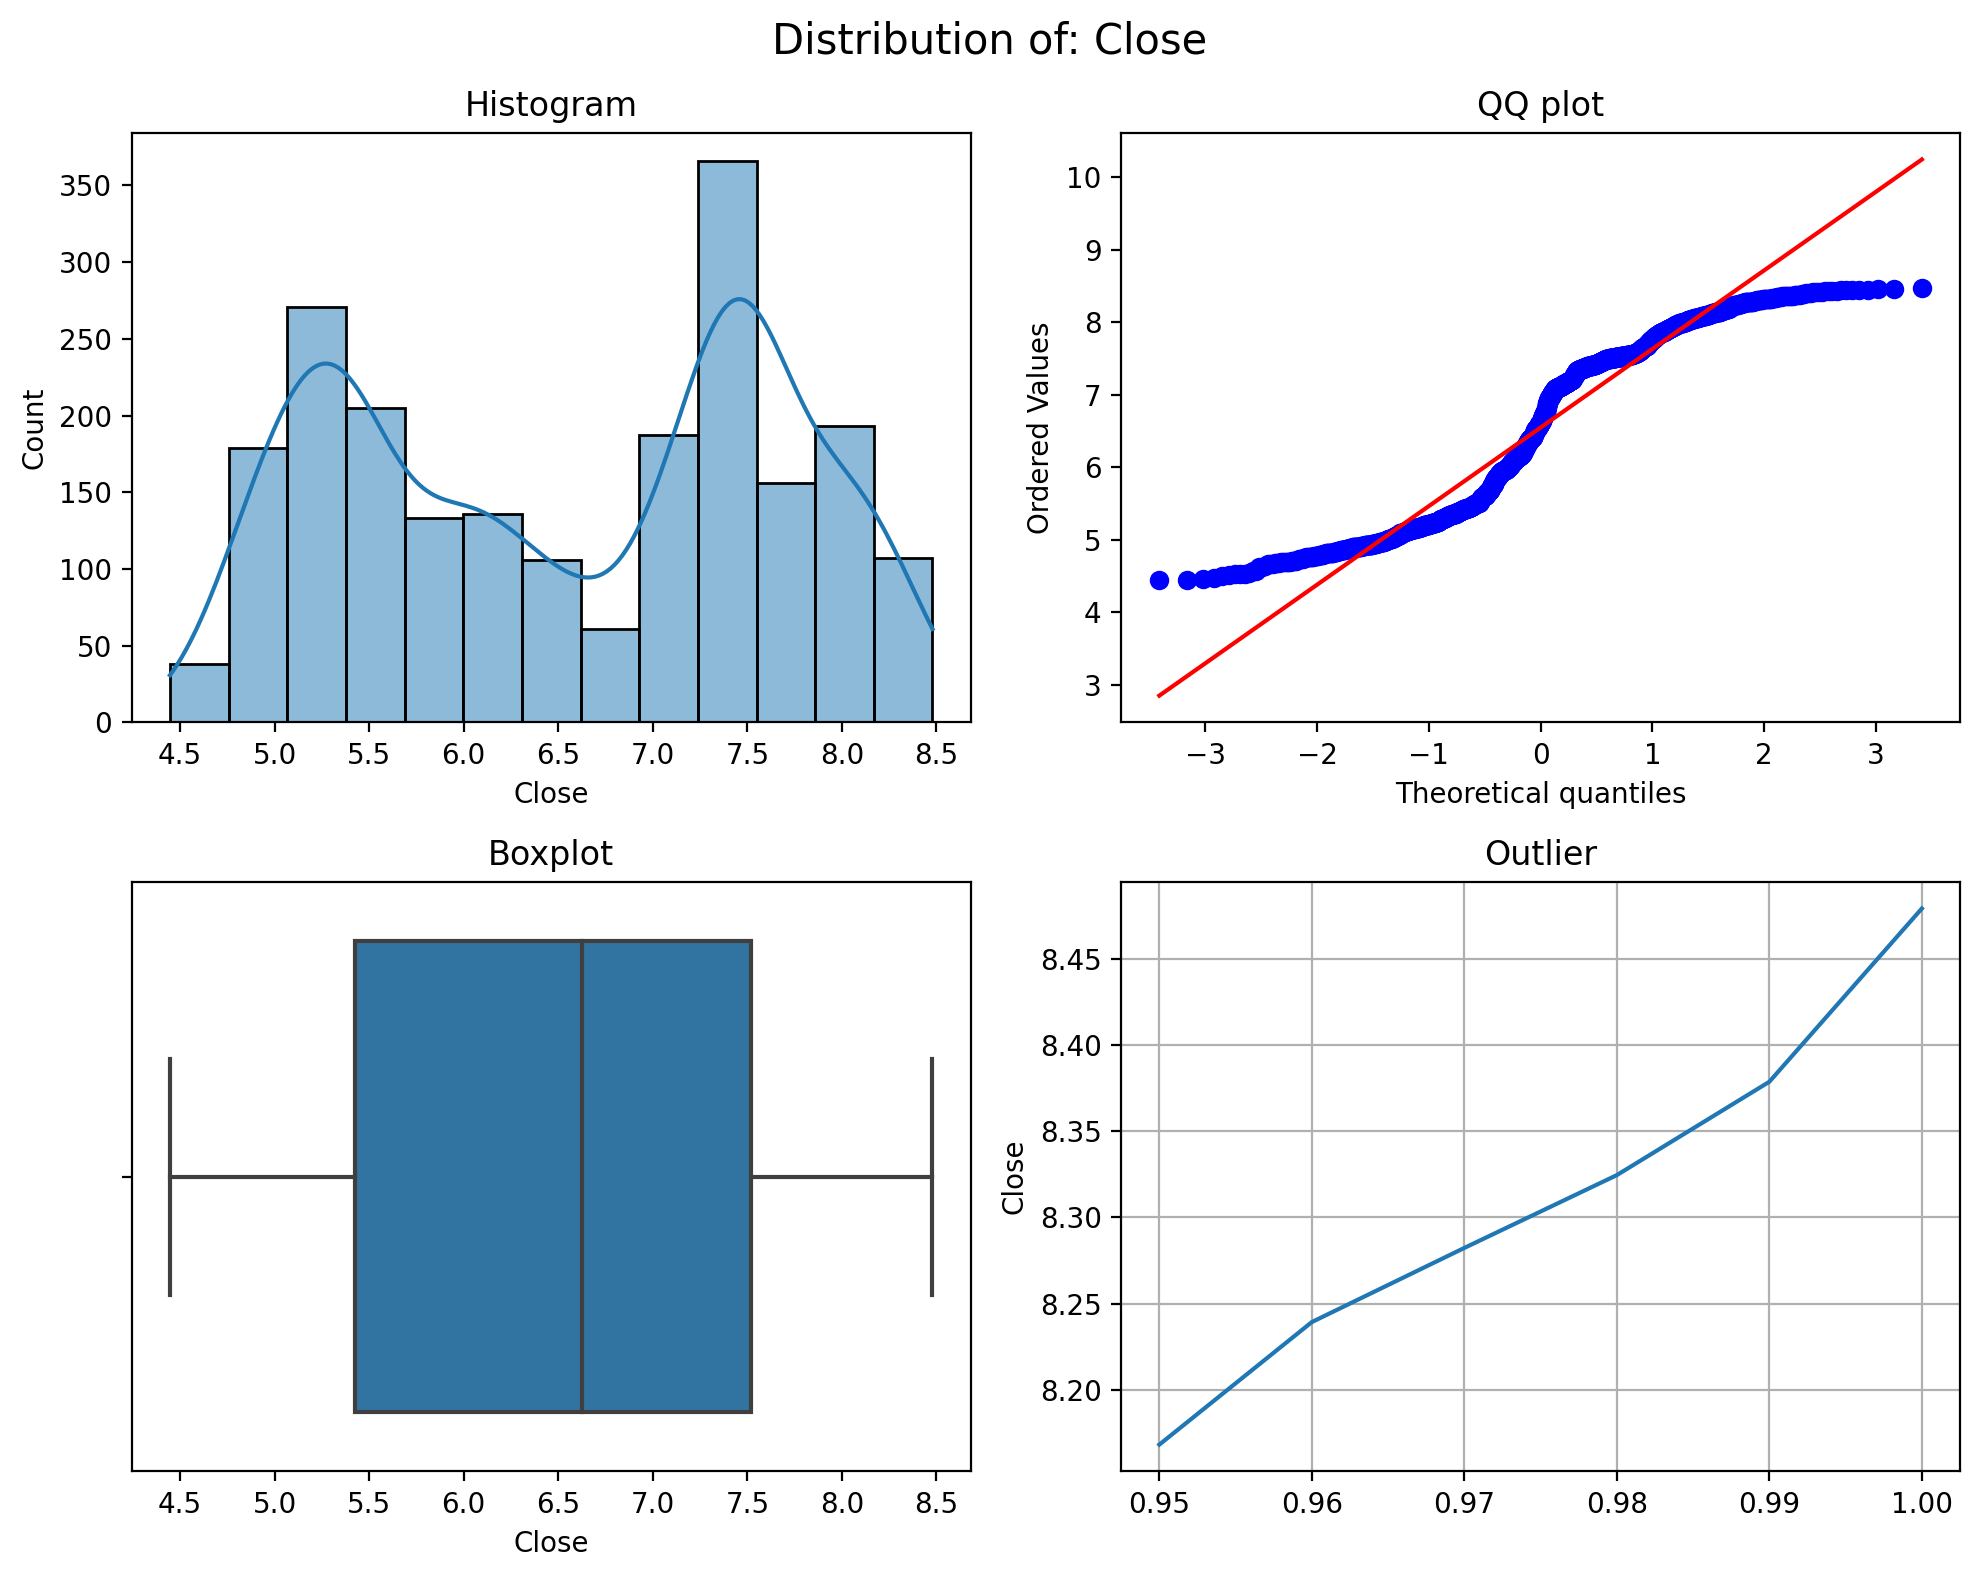

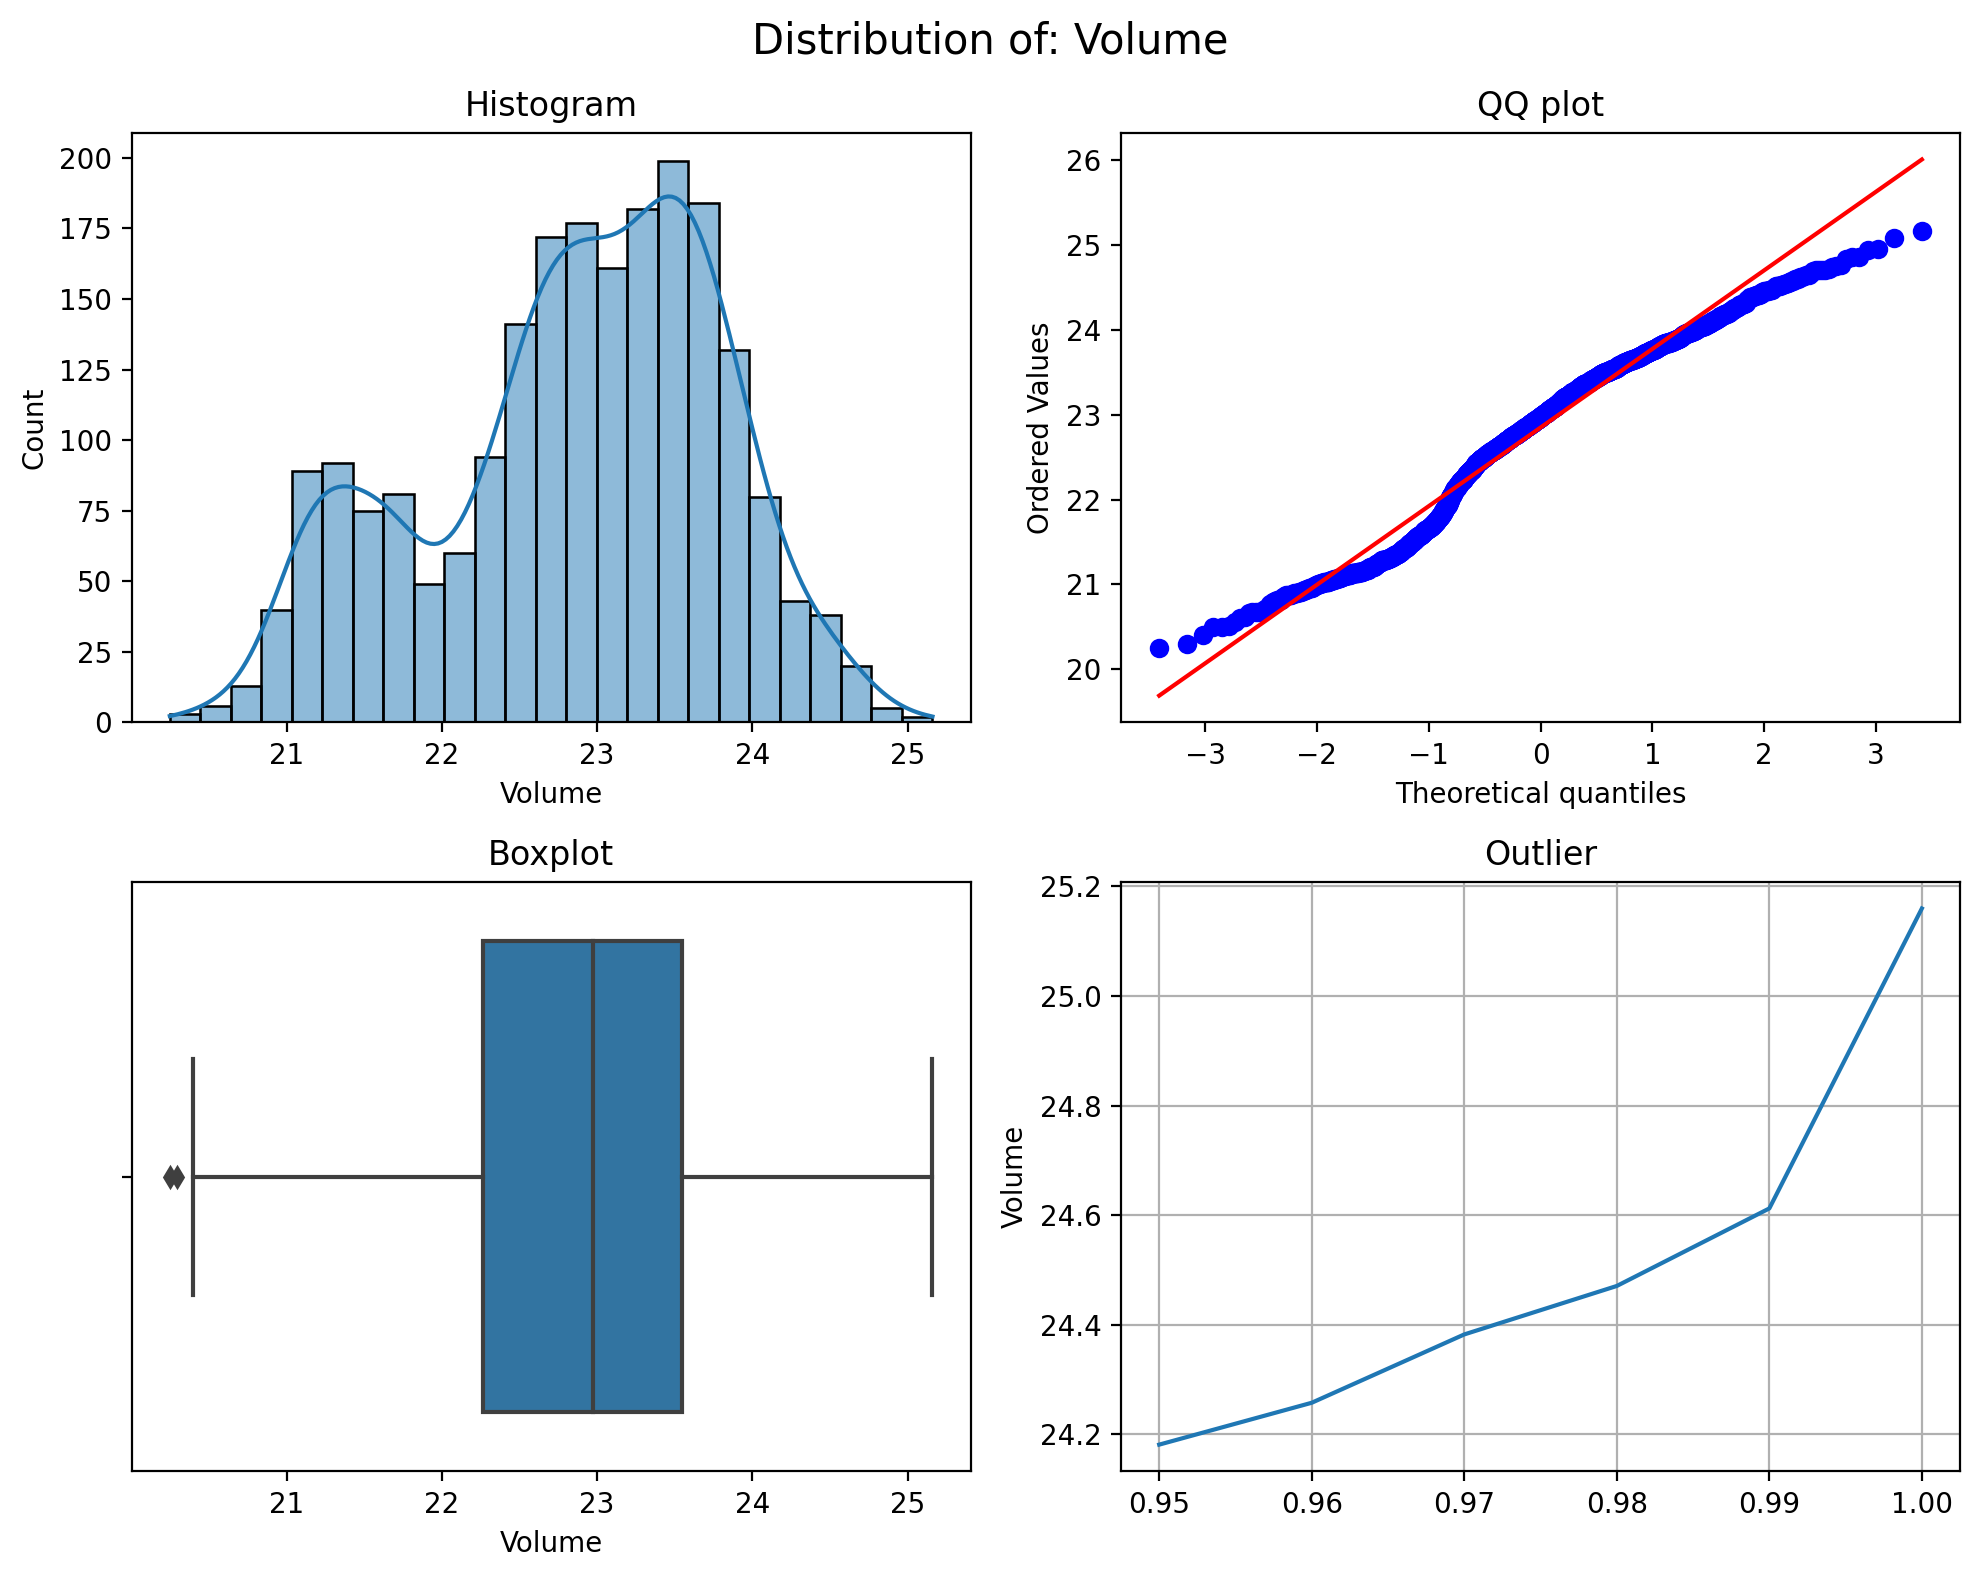

In [19]:
df_ETH_transformed['Date'] = df_ETH['Date']

# log transformation and check
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_ETH_transformed[col] = np.log1p(df_ETH[col])
    summary_numerical_dist(df_ETH_transformed, col, .95, 1)

In [20]:
df_ETH_transformed.set_index('Date', inplace = True)
df_ETH_transformed.head()
# sets the 'Date' column as the index of the DataFrame 

,Open,High,Low,Close,Volume
Date,,,,,
2017-11-09,5.735426,5.800461,5.730282,5.774191,20.610377
2017-11-10,5.773529,5.786032,5.688811,5.704625,20.602212
2017-11-11,5.702402,5.769736,5.701085,5.754732,20.551648
2017-11-12,5.754761,5.768799,5.702158,5.733043,21.201659
2017-11-13,5.730181,5.797318,5.730181,5.761158,20.764302


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler_not_y = MinMaxScaler()
scaler_y = MinMaxScaler()
#scaler_not_y = MinMaxScaler(): This line initializes an instance of the MinMaxScaler class and assigns it to the variable scaler_not_y. 
# This scaler object will be used to scale features (independent variables) that are not the target variable (y).

# scaler_y = MinMaxScaler(): This line initializes another instance of the MinMaxScaler class and assigns it to the variable scaler_y. 
# This scaler object will be used to scale the target variable (y).

# After creating these scaler objects, you typically apply them to the respective datasets to scale the features and target variable to the desired range.
# For instance, you can use the fit_transform method to fit the scaler to the data and transform it simultaneously, or you can use fit to compute the minimum and maximum values for scaling and later use transform on new data.

In [22]:
# scaling
def scale_data(data):

    arr_not_y = scaler_not_y.fit_transform(data.drop(['Close'], axis = 1).values)
    arr_y = scaler_y.fit_transform(data['Close'].values.reshape(-1, 1))

    arr_result = np.concatenate([arr_y, arr_not_y], 1)
    
    return arr_result
#function scale_data(data) that scales the data using the MinMaxScaler objects scaler_not_y and scaler_y, and then concatenates the scaled features and target variable together.

In [23]:
arr_ETH_transformed = scale_data(df_ETH_transformed)

# 4. Modeling

## 4.1. Make Sequence and Split

In [24]:
# function that make sequence data
def create_sequences(data, seq_length):
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length]) # data of past days
        y.append(data[i + seq_length][0]) # 'Close' of next day
        
    return np.array(X), np.array(y)

In [25]:
seq_length = 10  # the number of past days to be used for predictions
X, y = create_sequences(arr_ETH_transformed, seq_length)

In [26]:
# split
train_size = int(len(X) * 0.70)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

## 4.2. Model Building

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [28]:
model_LSTM = Sequential([
    LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (seq_length, 5)),
    LSTM(units = 50, activation = 'relu', return_sequences = False),
    Dense(units = 1)
])

model_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')

#defines an LSTM neural network model with two LSTM layers followed by a Dense output layer and compiles it with the Adam optimizer and mean squared error loss function.
#This model is designed for a regression task, where it predicts a continuous value based on input sequences.









## 4.3. Training

In [29]:
model_LSTM_history = model_LSTM.fit(
    X_train, y_train,
    epochs = 50,
    batch_size = 64,
    validation_data = (X_test, y_test)
)
# snippet is training the previously defined LSTM model (model_LSTM) using the training data (X_train and y_train)

Epoch 1/50
24/24 [==============================] - 5s 45ms/step - loss: 0.0617 - val_loss: 0.0174
Epoch 2/50
24/24 [==============================] - 0s 21ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/50
24/24 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 8.0231e-04
Epoch 4/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 6.9091e-04
Epoch 5/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 5.7814e-04
Epoch 6/50
24/24 [==============================] - 0s 20ms/step - loss: 9.8953e-04 - val_loss: 5.1850e-04
Epoch 7/50
24/24 [==============================] - 0s 21ms/step - loss: 9.4376e-04 - val_loss: 5.8836e-04
Epoch 8/50
24/24 [==============================] - 0s 20ms/step - loss: 8.6078e-04 - val_loss: 5.5013e-04
Epoch 9/50
24/24 [==============================] - 0s 21ms/step - loss: 8.2436e-04 - val_loss: 4.7527e-04
Epoch 10/50
24/24 [==============================] - 1s 24ms/step

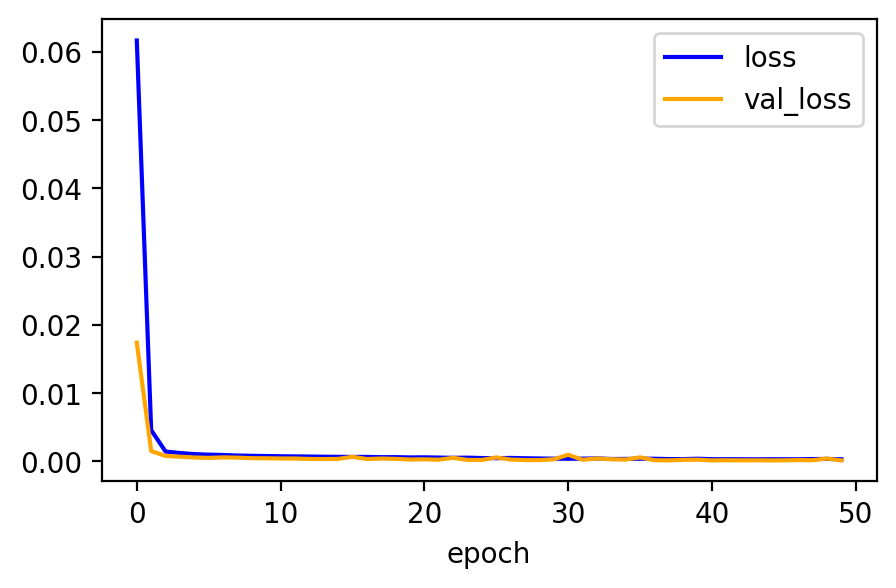

In [30]:
# loss curve
plt.figure(figsize = (5, 3))

plt.plot(model_LSTM_history.history['loss'], color = "blue")
plt.plot(model_LSTM_history.history['val_loss'], color = "orange")

plt.xlabel("epoch")
plt.legend(['loss','val_loss'])

plt.show()
# segment is plotting the training and validation loss values over epochs to visualize,
#how the model's performance changes during training.

## 4.4. Evaluation

In [31]:
# prediction
y_pred = np.concatenate([model_LSTM.predict(X_train), model_LSTM.predict(X_test)])
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_pred_rescaled = np.expm1(y_pred_rescaled)

# snippet takes the predictions made by an LSTM model, rescales them to their original range using the inverse transformation of the scaling applied during preprocessing,
# and then undoes any logarithmic transformation that may have been applied earlier.
# The result is a set of predictions in the original scale of the target variable.

20/20 [==============================] - 0s 5ms/step


In [32]:
# inverse scaling: actual y
y_rescaled = np.expm1(scaler_y.inverse_transform(y.reshape(-1, 1)))

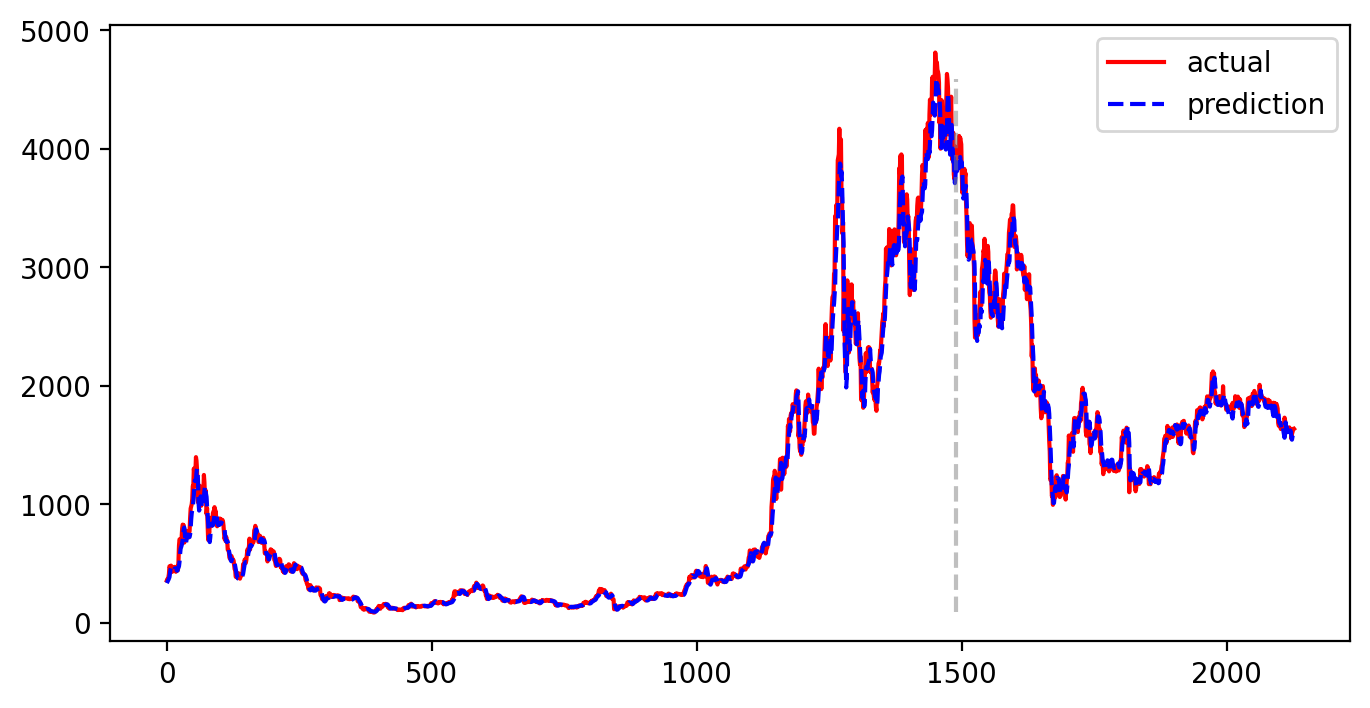

In [33]:
# plotting
plt.figure(figsize = (8, 4), facecolor = "white")

plt.plot(y_rescaled, color = "red")
plt.plot(y_pred_rescaled, color = "blue", linestyle = "--")
plt.vlines(
    train_size,
    ymin = y_pred_rescaled.min(), ymax = y_pred_rescaled.max(),
    color = "grey",
    linestyle = "--",
    alpha = 0.5
)

plt.legend(['actual','prediction'])

plt.show() 

In [34]:
# df for analyze residual
df_ETH_LSTM_resid = pd.concat([pd.DataFrame(y_rescaled, columns = ['Close_actual']),
                               pd.DataFrame(y_pred_rescaled, columns = ['Close_pred'])],
                              axis = 1)
df_ETH_LSTM_resid['Date'] = df_ETH['Date']
df_ETH_LSTM_resid['resid'] = df_ETH_LSTM_resid['Close_pred'] - df_ETH_LSTM_resid['Close_actual']

# check
df_ETH_LSTM_resid.head()

,Close_actual,Close_pred,Date,resid
0,354.385986,333.058624,2017-11-09,-21.327362
1,366.730011,341.806396,2017-11-10,-24.923615
2,360.401001,352.669678,2017-11-11,-7.731323
3,380.652008,360.346130,2017-11-12,-20.305878
4,410.165985,370.899963,2017-11-13,-39.266022


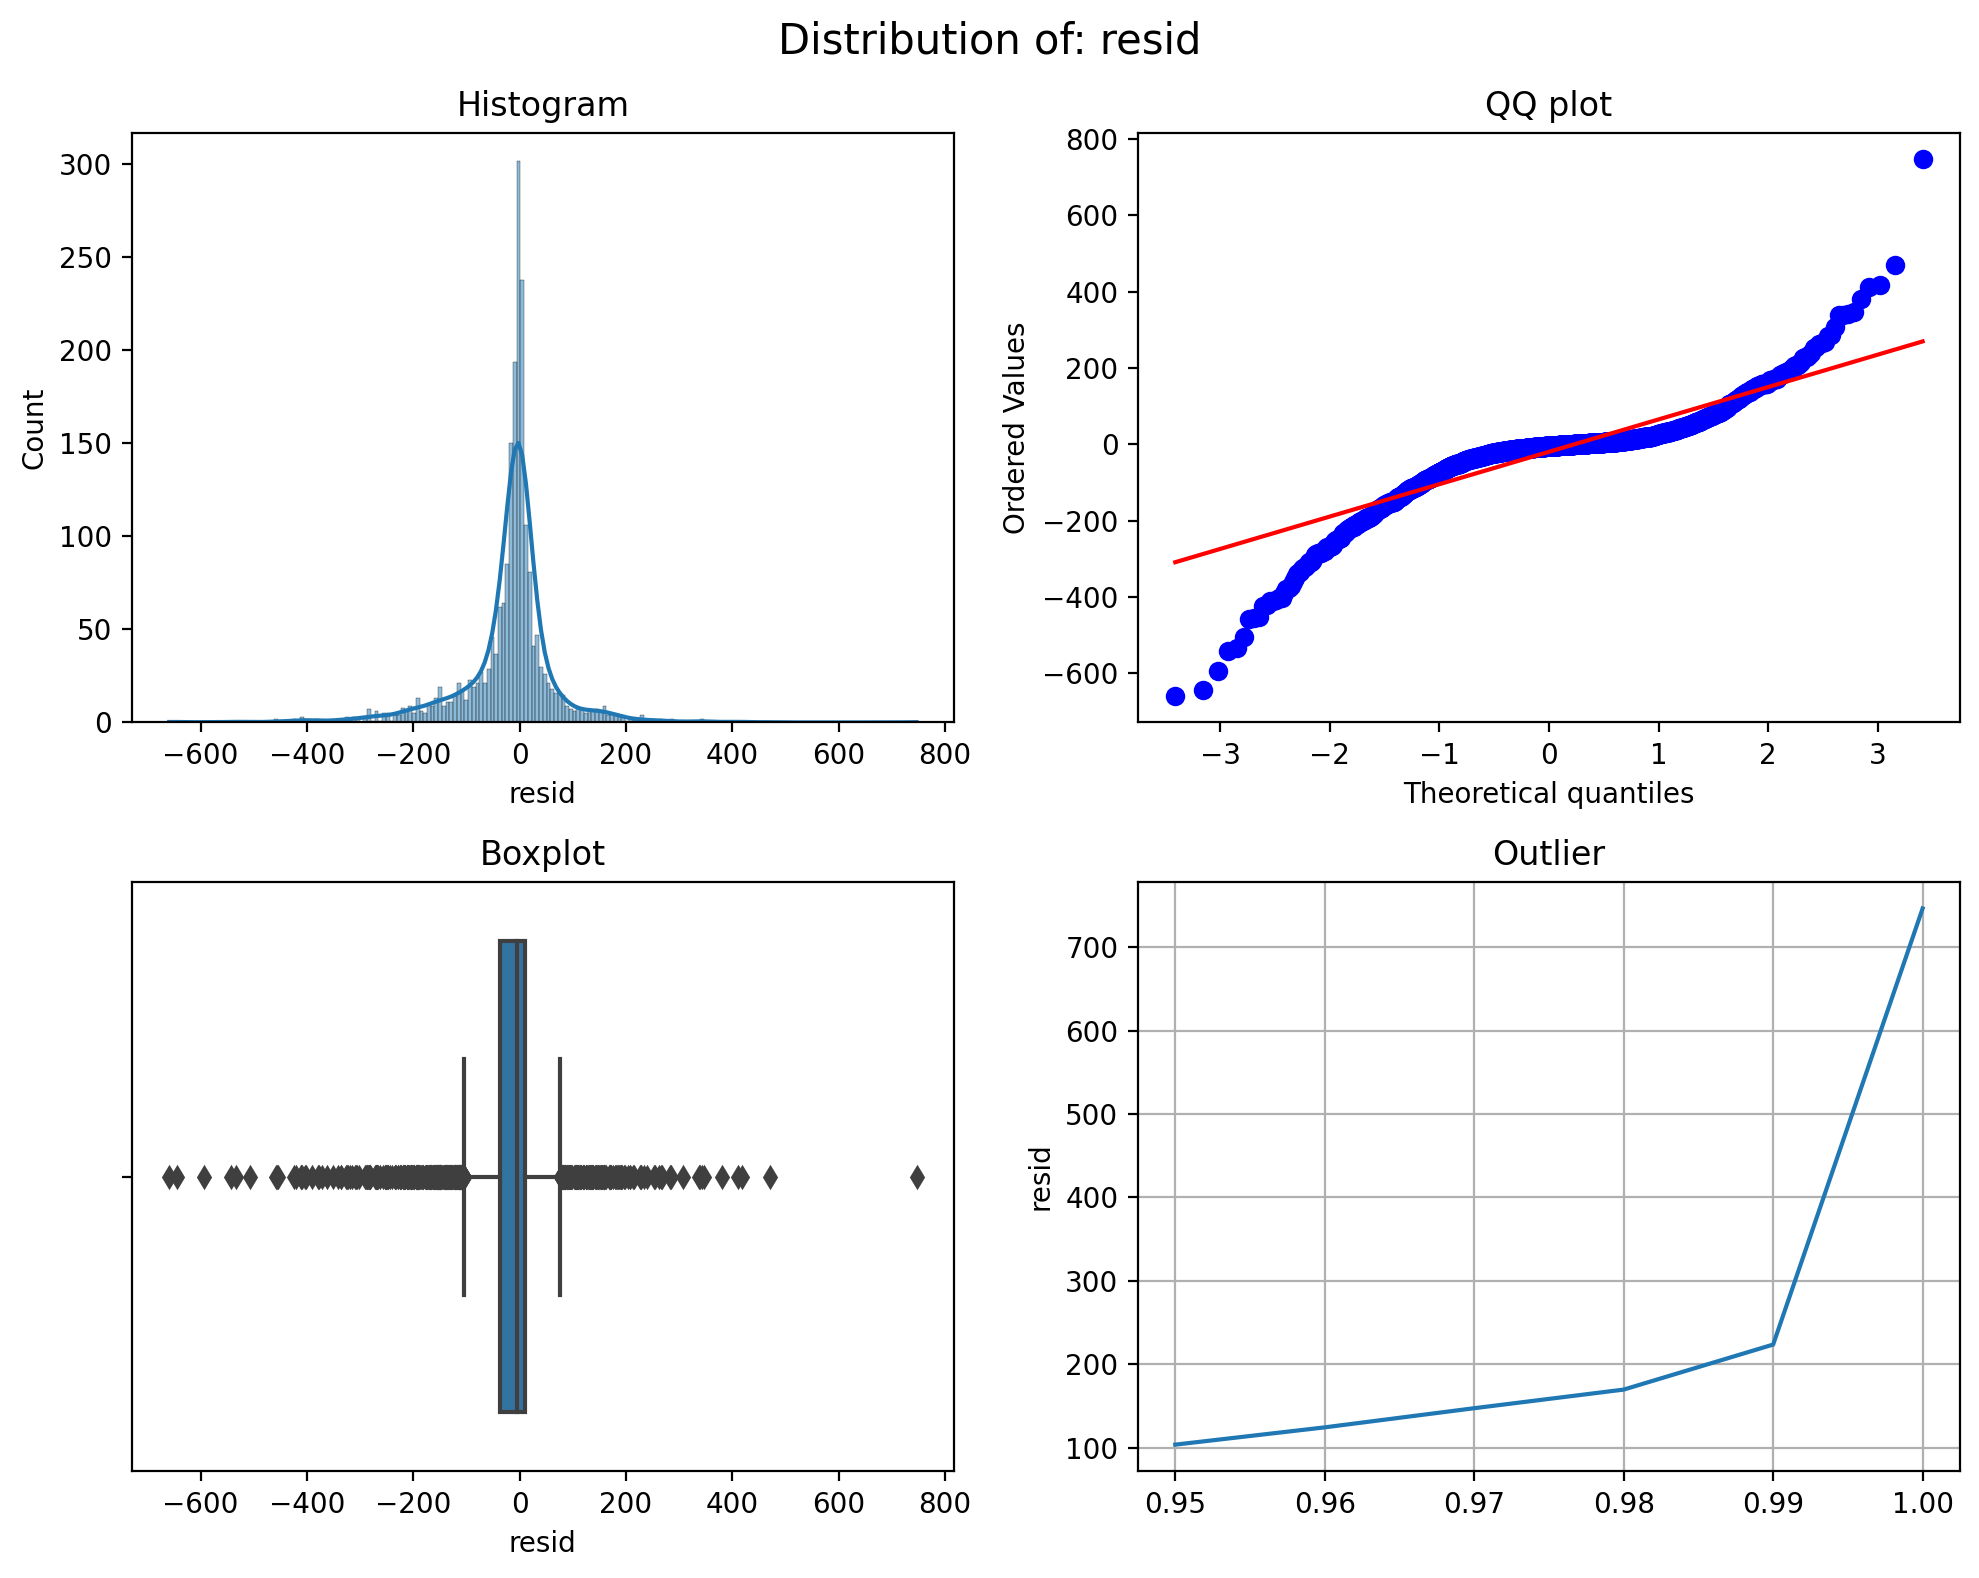

In [35]:
summary_numerical_dist(df_ETH_LSTM_resid, 'resid', .95, 1)

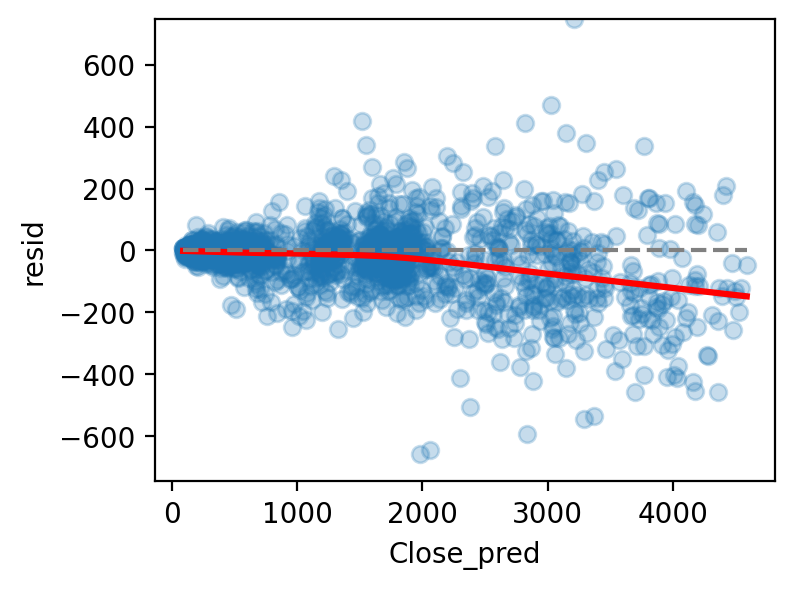

In [36]:
# residual plot
plt.figure(figsize = (4, 3), facecolor = "white")

sns.regplot(
    data = df_ETH_LSTM_resid,
    x = 'Close_pred', y = 'resid',
    lowess = True,
    line_kws = {'color': 'red'},
    scatter_kws = {'alpha': 0.25}
)

plt.hlines(
    y = 0, xmin = df_ETH_LSTM_resid['Close_pred'].min(), xmax = df_ETH_LSTM_resid['Close_pred'].max(),
    linestyle = "--",
    color = "grey"
)

ylim_max = max(abs(df_ETH_LSTM_resid['resid'].min()), abs(df_ETH_LSTM_resid['resid'].max()))
plt.ylim(-ylim_max, ylim_max)

plt.show()

# 5. Conclusion

Overall, the prediction performance was not bad. However, **relying on such time series models for investment can be challenging and risky in the market**.  
And it seems that there are minor deviations from the assumptions of normality and homoskedasticity in the residuals.

Again, please feel free to comment for suggestions! Thank you :)